# Analyse Exploratoire du jeu de Données `OpenFoodFacts`
*Les liens ne fonctionnent pas lorsque le notebook est affiché sur Github*

* [1. Objectif du projet](#P01)
* [2. Présentation générale du jeu de données](#P02)
* [3. Préselection des colonnes utiles](#P03)
* [4. Nettoyage du jeu de données](#P04)
    * [Suppression des lignes vides](#clean_empties)
    * [Suppression des doublons](#clean_duplicates)
    * [Suppression des valeurs aberrantes](#clean_outliers)
    * [Corrélations linéaires](#clean_correlations)
    * [Imputations des valeurs manquantes](#clean_imputations)
    * [Suppression des lignes aux valeurs nutritionnelles illogiques](#clean_logic)
* [5. Démarche méthodologique d’analyse de données](#P05)
    * [Analyses univariées](#analysis_univariate)
    * [Analyses multivariées](#analysis_multivariate)
    * [Analyse en composantes principales](#pca)
    * [Test statistique](#anova)
* [6. Conclusions](#conclusion)

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from scipy import stats
from sklearn.preprocessing import StandardScaler

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# 1. Objectif  <a class="anchor" id="P01"></a>

Le **nutri-grade** est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce grade à partir des indications disponibles sur les étiquettes des produits *(ou même simplement en scannant le code-barre)*.

---

En cherchant sur le site https://www.santepubliquefrance.fr on peut trouver des [informations](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce nutri-grade.

> *Éléments **défavorables** au score*
> 
> - Apport calorique pour cent grammes.
> - Teneur en sucre.
> - Teneur en graisses saturées.
> - Teneur en sel.

> *Éléments **favorables** au score*
> 
> - Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
> - Teneur en fibres.
> - Teneur en protéines.

> *Précisions utiles*
> 
> - Pour calculer la teneur de fruits et légumes, les féculents (tel que pomme de terre, patate douce, taro, manioc et tapioca) ne sont pas pris en compte.
> - Pour les fromages, la teneur en protéines est toujours prise en compte car celle-ci est liée à celle en calcium. Ceci améliore le nutri-score des fromages et la cohérence entre celui-ci et les recommandations nutritionnelles du Haut Conseil de la Santé Publique. Celles-ci recommandent en effet de consommer des produits laitiers plusieurs fois par jour. 

---

**Nous allons donc vérifier s'il est possible de calculer le nutri-grade à partir des indicateurs nutritionnels disponibles sur les étiquettes des produits.**

---
---

# 2. Présentation générale du jeu de données <a class="anchor" id="P02"></a>

Le [jeu de données](https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv) utilisé dans le cadre de l'appel à projets de l'agence *Santé Publique France* consistant à rendre les données de santé plus accessibles, est une liste de **2.251.894 produits alimentaires** répertoriés par les volontaires de l'association [Open Food Facts](https://world.openfoodfacts.org).

Chacun des produits référencé est décrit par 4 types d'informations:
- Les **informations générales** sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de **tags** : catégorie du produit, localisation, origine, etc.
- Les **ingrédients** composant les produits et leurs additifs éventuels.
- Des **informations nutritionnelles** : quantité en grammes d’un nutriment pour 100 grammes du produit.

---

> **NOTE IMPORTANTE:** Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée,
<br> donc **nous avons crée** *(dans Cleaning_01_Preselection.ipynb)* **un jeu de données ne gardant que 36 des 186 colonnes initiales, que nous allons utiliser ici**.

---

In [2]:
# Commençons par charger les colonnes (et leur dtype) sélectionnées dans le premier notebook

filename = 'data/dtypes_low.csv'
dtypes_df = pd.read_csv(filename, sep=',', index_col=0)
cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

In [3]:
# Puis chargeons le jeu de données réduit

filename = 'data/en.openfoodfacts.org.products.csv'
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_keep) #, nrows=10000)

In [4]:
# Transformons les valeurs neutres par des `None` dans les colonnes numériques.

for cat in data.select_dtypes(exclude=np.number).columns:
    data[cat].replace(['unknown',np.NaN, "NaN"], None, inplace=True)

In [5]:
# Renommons la colonne 'fruits-vegetables-nuts-estimate-from-ingredients_100g' qui est beaucoup trop longue

data.rename(columns={'fruits-vegetables-nuts-estimate-from-ingredients_100g':'FVN_estimate_100g'}, inplace=True)

## Explorons le jeu de données

In [6]:
data.head(3)

code                                                url  \
0     00000000000000225  http://world-en.openfoodfacts.org/product/0000...   
1  00000000000003429145  http://world-en.openfoodfacts.org/product/0000...   
2         0000000000017  http://world-en.openfoodfacts.org/product/0000...   

       product_name quantity categories_tags labels_tags  \
0    jeunes pousses     None            None        None   
1           L.casei     None            None        None   
2  Vitória crackers     None            None        None   

                                    ingredients_tags allergens traces_tags  \
0                                               None      None        None   
1  en:semi-skimmed-milk,en:dairy,en:milk,es:azuca...      None        None   
2                                               None      None        None   

  serving_size  ...  sugars_100g  fiber_100g proteins_100g  salt_100g  \
0         None  ...          NaN         NaN           NaN        NaN   
1         None  ...          9.8         NaN           2.7        0.1   
2         None  ...         15.0         NaN           7.8        1.4   

  sodium_100g vitamin-a_100g vitamin-c_100g calcium_100g iron_100g  \
0         NaN            NaN            NaN          NaN       NaN   
1        0.04            NaN            NaN          NaN       NaN   
2        0.56            NaN            NaN          NaN       NaN   

  FVN_estimate_100g  
0               NaN  
1               0.0  
2               NaN  

[3 rows x 36 columns]

In [7]:
print(f"Le jeu de données contient {data.shape[1]} colonnes et {data.shape[0]} lignes")

Le jeu de données contient 36 colonnes et 10000 lignes


---

### 2.1 Survolons les données numériques

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [9]:
data.describe().T

count     mean      std     min     25%      50%  \
serving_quantity   4672.000   85.111  525.022   0.000  28.000   40.000   
additives_n        5001.000    3.352    4.416   0.000   0.000    2.000   
nutriscore_score   3741.000   11.390    9.390 -13.000   3.000   13.000   
energy_100g        8362.000 1251.991 1077.201   0.000 456.000 1255.000   
fat_100g           8288.000   14.646   17.846   0.000   0.700    7.140   
saturated-fat_100g 7648.000    6.133    8.955   0.000   0.050    2.588   
trans-fat_100g     3040.000    0.055    0.941   0.000   0.000    0.000   
cholesterol_100g   3120.000    0.022    0.052   0.000   0.000    0.006   
carbohydrates_100g 8314.000   32.600   32.908   0.000   6.780   25.913   
sugars_100g        8070.000   17.195   26.208   0.000   1.400    6.250   
fiber_100g         4883.000    3.210   15.189   0.000   0.000    1.600   
proteins_100g      8321.000    9.102   13.163   0.000   1.786    5.560   
salt_100g          7697.000    2.590   35.327   0.000   0.130    0.595   
sodium_100g        7697.000    1.036   14.117   0.000   0.052    0.238   
vitamin-a_100g     2676.000    0.366   11.682   0.000   0.000    0.000   
vitamin-c_100g     2710.000    0.046    1.998   0.000   0.000    0.000   
calcium_100g       3180.000    0.348   12.962   0.000   0.017    0.071   
iron_100g          3228.000    0.009    0.426   0.000   0.000    0.001   
FVN_estimate_100g  4999.000    5.971   18.698   0.000   0.000    0.000   

                        75%       max  
serving_quantity     99.000 35371.000  
additives_n           5.000    33.000  
nutriscore_score     19.000    36.000  
energy_100g        1795.000 53000.000  
fat_100g             23.333   222.000  
saturated-fat_100g    8.209   100.000  
trans-fat_100g        0.000    44.250  
cholesterol_100g      0.029     1.654  
carbohydrates_100g   54.297  1550.000  
sugars_100g          27.198  1400.000  
fiber_100g            3.571  1000.000  
proteins_100g        10.920   300.000  
salt_100g             1.272  1880.000  
sodium_100g           0.509   750.000  
vitamin-a_100g        0.000   577.000  
vitamin-c_100g        0.002   104.000  
calcium_100g          0.143   731.000  
iron_100g             0.002    24.200  
FVN_estimate_100g     0.000   125.800

> On remarque que beaucoup de colonnes numériques ont des valeurs `min`, `max` *(et donc `mean` et `std`)* clairement hors normes.
>
> **RECOMMANDATIONS:** Il faudra s'occuper de ces valeurs aberrantes lors du nettoyage.

---

### 2.2 Survolons les données nominales

In [10]:
data.describe(exclude="number").T

count unique  \
code              10000  10000   
url               10000  10000   
product_name       9615   8520   
quantity           1178    485   
categories_tags    4798    993   
labels_tags         912    269   
ingredients_tags   4999   4148   
allergens          1111     94   
traces_tags         212     93   
serving_size       4684   1626   
additives_tags     3440   1767   
nutriscore_grade   3741      5   
nova_group         4504      4   
pnns_groups_1      3615     10   
pnns_groups_2      3615     38   
states_tags       10000    457   
main_category      4798    846   

                                                                top  freq  
code                                              00000000000000225     1  
url               http://world-en.openfoodfacts.org/product/0000...     1  
product_name                                      Pure whey protein    19  
quantity                                                      16 oz    72  
categories_tags                                           en:snacks   340  
labels_tags                                              en:organic   193  
ingredients_tags  en:pasteurised-milk,en:dairy,en:milk,en:lactic...    22  
allergens                                                   en:milk   306  
traces_tags                                                 en:nuts    22  
serving_size                                           1 ONZ (28 g)   269  
additives_tags                                     en:e322,en:e322i   306  
nutriscore_grade                                                  d  1099  
nova_group                                                        4  3587  
pnns_groups_1                                         Sugary snacks  1419  
pnns_groups_2                                                Sweets   774  
states_tags       en:to-be-completed,en:nutrition-facts-complete...  1840  
main_category                                             en:snacks   340

> Sur la base des colonnes `code` et `url` *(sensées être uniques)*, on remarque qu'il y a au moins un doublon.
>
> **RECOMMANDATIONS:** Il faudra s'occuper de ces doublons lors du nettoyage.

---

### 2.3 Affichons les taux de valeurs manquantes pour chaque colonne.

In [11]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes / présentes et leur taux

def print_fill_rate(dataset, col_array):
    fill_count = dataset[col_array].notnull().sum()
    fill_ratio = fill_count/dataset.shape[0]*100.0
    
    total = dataset.shape[0]
    max_size = max([len(x) for x in dataset.columns])
    col_size = 15
    
    print(f"{'COLONNE'.rjust(max_size)} | {'LIGNES VIDES'.center(col_size)} | {'REMPLISSAGE'.rjust(col_size)} \n{'-'*(max_size+col_size*2+10)}")
    
    for k, v in zip(fill_count.keys(), fill_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(max_size)} | {total-v:15} | {fraction:15.2f}%")
        
    return fill_ratio

In [12]:
fill_ratio = print_fill_rate(data, data.columns)

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
----------------------------------------------------------
              code |               0 |          100.00%
               url |               0 |          100.00%
      product_name |             385 |           96.15%
          quantity |            8822 |           11.78%
   categories_tags |            5202 |           47.98%
       labels_tags |            9088 |            9.12%
  ingredients_tags |            5001 |           49.99%
         allergens |            8889 |           11.11%
       traces_tags |            9788 |            2.12%
      serving_size |            5316 |           46.84%
  serving_quantity |            5328 |           46.72%
       additives_n |            4999 |           50.01%
    additives_tags |            6560 |           34.40%
  nutriscore_score |            6259 |           37.41%
  nutriscore_grade |            6259 |           37.41%
        nova_group |            5496 |       

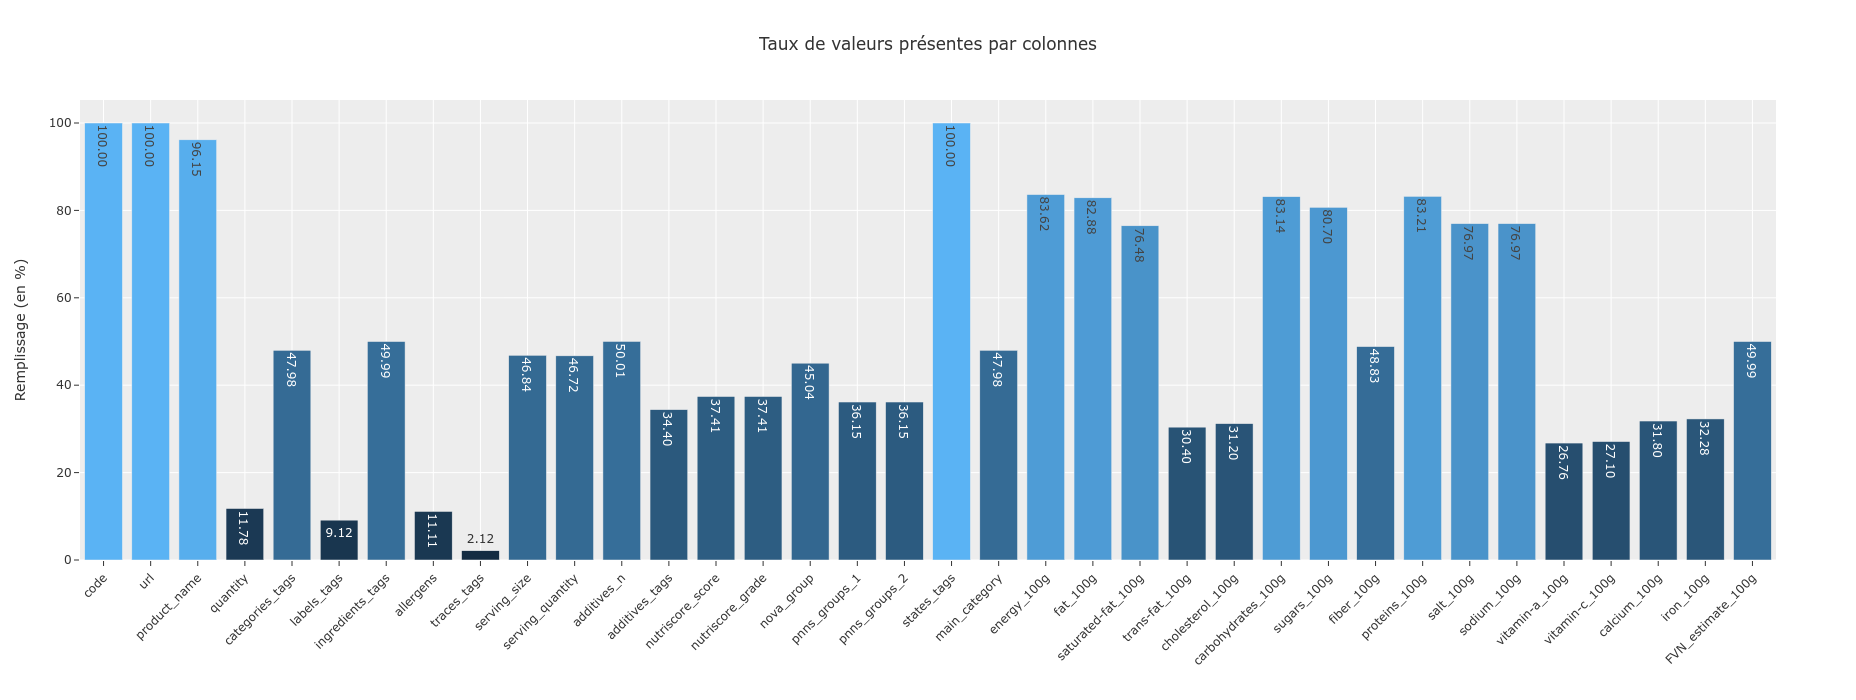

In [13]:
fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=700,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
             text=[f"{x:.2f}" for x in fill_ratio_df.fill_rate],
            )

fig.update_coloraxes(showscale=False)
fig.update_xaxes(tickangle = -45)
fig.show()

---
---

# 3. Préselection des colonnes utiles <a class="anchor" id="P03"></a>

Malgré une première sélection, il reste encore beaucoup de colonnes dans ce jeu de données. Nous pourrions simplement nous appuyer sur les indications de la documentation du *nutri-grade* pour réduire notre sélection aux colonnes correspondant aux élements favorables ou défavorables, mais il est préférable d'étudier tous les indicateurs nutritionnels dont nous disposons encore pour voir ce qu'il en est vraiment.

- Nous allons donc conserver tous les indicateurs nutritionnels; `*_100g`
- Nous allons prendre la variable de catégorisation; `pnns_groups_2` *(voir Cleaning_02_Nutriscore.ipynb pour l'explication de ce choix)*
- Nous allons prendre deux variables d'identification du produit pour éliminer les doublons; `code` et `product_name`
- Nous allons prendre les variables de scoring que nous voulons prédire et donc confronter aux autres variables; `nutriscore_score` et `nutriscore_grade`

In [14]:
var_selected = {x for x in data.columns if x.endswith('_100g')}

In [15]:
var_selected.add('pnns_groups_2')

In [16]:
var_selected.add('code')
var_selected.add('product_name')

In [17]:
var_selected.add('nutriscore_score')
var_selected.add('nutriscore_grade')
# var_selected.add('nova_group')

### Colonnes séléctionnées pour une application de prédiction du Nutri-grade

In [18]:
var_selected = sorted(sorted(var_selected), key=lambda x: x.endswith('_100g'), reverse=False)
print(f"{var_selected}")

['code', 'nutriscore_grade', 'nutriscore_score', 'pnns_groups_2', 'product_name', 'FVN_estimate_100g', 'calcium_100g', 'carbohydrates_100g', 'cholesterol_100g', 'energy_100g', 'fat_100g', 'fiber_100g', 'iron_100g', 'proteins_100g', 'salt_100g', 'saturated-fat_100g', 'sodium_100g', 'sugars_100g', 'trans-fat_100g', 'vitamin-a_100g', 'vitamin-c_100g']


In [19]:
data_nutri = data[[*var_selected]]

---
---

# 4. Nettoyage du jeu de données <a class="anchor" id="P04"></a>

In [20]:
def print_current_size(data, size=[]):
    num_lines = data.shape[0]
    diff = ""
    if size != [] :
        diff = f"({size[-1]-num_lines} lignes de moins)"
    size.append(num_lines)
    print(f"A ce stade le jeu de données contient {num_lines} lignes {diff}")

In [21]:
data_clean = data_nutri.copy()
print_current_size(data_clean)

A ce stade le jeu de données contient 10000 lignes 


--- 

### 4.1 Suppression des lignes où toutes les valeurs nutritionnelles sont vides <a class="anchor" id="clean_empties"></a>

In [22]:
selection = list(data_clean.select_dtypes(include=np.number).columns)
selection.remove('nutriscore_score')

In [23]:
data_clean = data_clean[data_clean[selection].notnull().apply(lambda x: any(x), axis=1)]
print_current_size(data_clean)

A ce stade le jeu de données contient 8760 lignes (1240 lignes de moins)


---

### 4.2 Suppression des doublons <a class="anchor" id="clean_duplicates"></a>

In [24]:
data_clean.drop_duplicates(subset=['code'], keep='first', inplace=True)

In [25]:
cols_without_code = list(data_clean.columns)
cols_without_code.remove("code")

In [26]:
data_clean.drop_duplicates(subset=cols_without_code, keep='first', inplace=True)
print_current_size(data_clean)

A ce stade le jeu de données contient 8575 lignes (185 lignes de moins)


---

### 4.3 Suppression des valeurs aberrantes <a class="anchor" id="clean_outliers"></a>

Les valeurs nutritionnelles `*_100g` ne peuvent logiquement pas dépasser les 100g, ni avoir moins de 0g.

Deux options se présentent à nous:
- a) Supprimer les lignes qui présentent des valeurs aberrantes en partant du principe que si une donnée de la ligne est fausse, les autres sont incertaines.
- b) Remplacer les valeurs aberrantes par des None et les imputer ensuite.

Nous allons donc procèder en deux temps... d'abord supprimer les lignes qui sont en dehors de l'intervalle logique [0,100], puis ensuite remplacer les valeurs aberrantes en regard des valeurs maximum connues pour un indicateur nutritionnel donnée.

In [27]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g') and x != 'energy_100g']

In [28]:
data_outliers_before = data_clean[var_nutri]

#### **a**) Supprimons les lignes dont les valeurs nutritionnelles sont hors intervalle [0,100] 
Sauf `energy_100g` qui est en kj et qui n'est pas concerné

In [29]:
# Définissons une fonction permettant de supprimer les lignes qui présentent des valeurs hors intervalle

def drop_row_values(dt, col_name, min_v=None, max_v=None):
    count_start = dt.shape[0]
    
    dt = dt[((dt[col_name].notnull()) & (dt[col_name] >= min_v) & (dt[col_name] <= max_v)) | (dt[col_name].isnull())]
        
    count_end = dt[col_name].shape[0]
    print(f"On a supprimé {count_start-count_end:6} lignes sur {col_name}")
        
    return dt

In [30]:
for col in var_nutri:
    data_clean = drop_row_values(data_clean, col, min_v=0, max_v=100)

On a supprimé      3 lignes sur FVN_estimate_100g
On a supprimé      1 lignes sur calcium_100g
On a supprimé      4 lignes sur carbohydrates_100g
On a supprimé      0 lignes sur cholesterol_100g
On a supprimé      1 lignes sur fat_100g
On a supprimé      1 lignes sur fiber_100g
On a supprimé      0 lignes sur iron_100g
On a supprimé      0 lignes sur proteins_100g
On a supprimé     14 lignes sur salt_100g
On a supprimé      0 lignes sur saturated-fat_100g
On a supprimé      0 lignes sur sodium_100g
On a supprimé      0 lignes sur sugars_100g
On a supprimé      0 lignes sur trans-fat_100g
On a supprimé      0 lignes sur vitamin-a_100g
On a supprimé      0 lignes sur vitamin-c_100g


In [31]:
print_current_size(data_clean)

A ce stade le jeu de données contient 8551 lignes (24 lignes de moins)


#### **b**) Remplaçons les valeurs nutritionnelles hors intervalle métier par des `None` *(pour pouvoir ensuite les imputer)*

En cherchant sur Internet on peut trouver les valeurs réelles maximales constatées pour plusieurs de ces colonnes, nous allons nous en servir pour

> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// **Cervelle de veau cuite**

> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// **Huile d'avocat**

> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// **Pain de friture**

> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// **Gélatine alimentaire**

> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// **Fructose**

> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `salt_100g` le maximum semble être à **100g** pour 100g /// **Sel blanc non iodé non fluoré**

> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// **Boudin noir**

> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// **Meloukhia en poudre**

> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// **Cannelle**

> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// **Huile d'avocat**

> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// **Huile d'avocat**

> Pour `vitamin-a_100g` le maximum semble être à **0.03g** (30 000 μg) pour 100g /// **Huile de de foie de morrue**

> Pour `vitamin-c_100g` le maximum semble être à **0.2g** (200 mg) pour 100g /// **Cassis**

In [32]:
max_values = {
    'cholesterol_100g':3.1,
    'fat_100g':100,
    'saturated-fat_100g':92.6,
    'proteins_100g':87.6,
    'sugars_100g':99.8,
    'carbohydrates_100g':99.8,
    'sodium_100g':39.1,
    'salt_100g':100,
    'iron_100g':0.0064,
    'calcium_100g':2,
    'fiber_100g':43.5,
    'energy_100g':3756.6,
    'vitamin-a_100g':0.03,
    'vitamin-c_100g':0.2,
}

In [33]:
# Définissons une fonction permettant d'appliquer un filtre sur les valeurs hors bornes

def clip_column_values(dt, col_name, min_v=None, max_v=None, min_new=None, max_new=None):
    count_start = dt[col_name].isin([max_new,min_new]).sum()
    
    if(min_v != None):
        dt[col_name].mask(dt[col_name] < min_v, min_new, inplace=True)
    if(max_v != None):
        dt[col_name].mask(dt[col_name] > max_v, max_new, inplace=True)
        
    count_end = dt[col_name].isin([max_new,min_new]).sum()
    
    print(f"On a modifié {count_end-count_start:6} lignes sur {col_name}")
        
    return dt

In [34]:
for col in max_values:
    data_clean = clip_column_values(data_clean, col, max_v=max_values[col], max_new=None)

On a modifié      0 lignes sur cholesterol_100g
On a modifié      0 lignes sur fat_100g
On a modifié      0 lignes sur saturated-fat_100g
On a modifié      0 lignes sur proteins_100g
On a modifié      0 lignes sur sugars_100g
On a modifié      0 lignes sur carbohydrates_100g
On a modifié      0 lignes sur sodium_100g
On a modifié      0 lignes sur salt_100g
On a modifié      0 lignes sur iron_100g
On a modifié      0 lignes sur calcium_100g
On a modifié      0 lignes sur fiber_100g
On a modifié      0 lignes sur energy_100g
On a modifié      0 lignes sur vitamin-a_100g
On a modifié      0 lignes sur vitamin-c_100g


In [35]:
print_current_size(data_clean)

A ce stade le jeu de données contient 8551 lignes (0 lignes de moins)


#### **c**) Comparons les valeurs numériques AVANT et APRÈS la suppression des valeurs aberrantes

In [36]:
data_outliers_after = data_clean[var_nutri]

In [37]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def select_describe1(stade):
    
    if stade == 'AVANT':
        print(data_outliers_before.describe().T)
    else:
        print(data_outliers_after.describe().T)

interact(select_describe1, stade=['APRES', 'AVANT'])

                      count   mean    std   min   25%    50%    75%     max
FVN_estimate_100g  4830.000  6.043 18.725 0.000 0.000  0.000  0.000 100.000
calcium_100g       3087.000  0.116  0.169 0.000 0.016  0.071  0.143   1.667
carbohydrates_100g 8086.000 32.009 26.911 0.000 7.000 25.605 54.000  99.300
cholesterol_100g   3028.000  0.022  0.052 0.000 0.000  0.006  0.029   1.654
fat_100g           8100.000 14.604 17.591 0.000 0.800  7.200 23.330 100.000
fiber_100g         4755.000  2.869  4.244 0.000 0.000  1.600  3.570  40.000
iron_100g          3029.000  0.001  0.001 0.000 0.000  0.001  0.002   0.006
proteins_100g      8123.000  9.040 12.519 0.000 1.835  5.560 11.000  87.000
salt_100g          7515.000  1.517  6.006 0.000 0.131  0.600  1.280  99.906
saturated-fat_100g 7508.000  6.069  8.836 0.000 0.020  2.588  8.041  86.670
sodium_100g        7511.000  0.586  2.229 0.000 0.052  0.240  0.511  38.463
sugars_100g        7882.000 16.819 20.907 0.000 1.400  6.250 26.670  99.000
trans-fat_10

<function __main__.select_describe1(stade)>

---

### 4.4 Corrélations linéaires <a class="anchor" id="clean_correlations"></a>

Afin de s'assurer que les imputations à venir ne modifient pas les rélations entre nos variables, il convient de les étudier même brièvement en amont.

> Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
> - Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
> - Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.
> 
> Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
> - -1 indique une relation forte dans le sens inverse (corrélation négative)
> - +1 indique une relation forte dans le même sens (corrélation positive)
> - 0  indique qu'il n'y a pas de relation.

#### **a**) Calculons donc les deux tables de corrélation

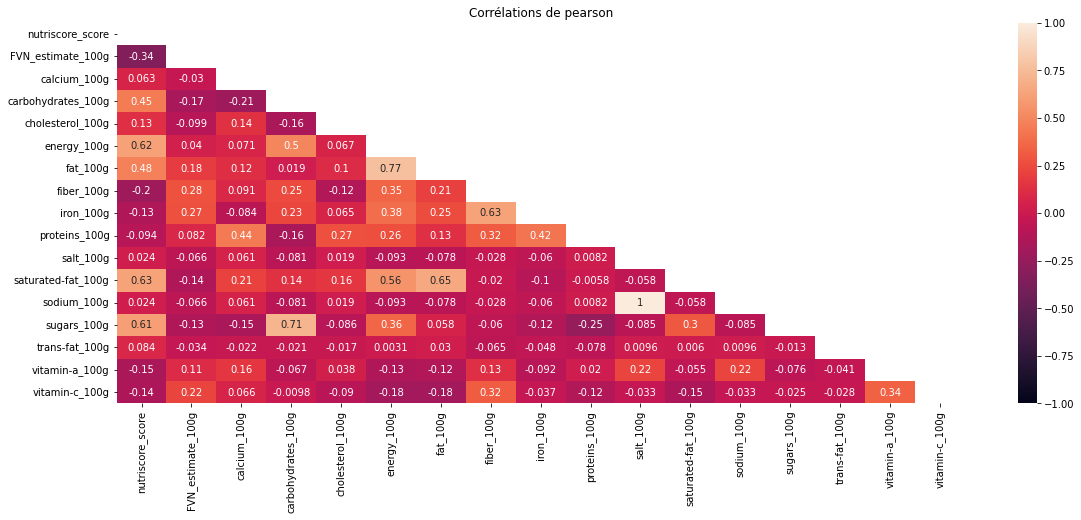

<function __main__.show_correlation1(correlation)>

In [38]:
data_corr_1 = data_clean.sample(frac=0.1).copy()

def show_correlation1(correlation):
    
    fig = plt.figure(figsize=(19,7))
    corr= data_corr_1.corr(method=correlation)
    matrix = np.triu(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
    ax.set_title(f'Corrélations de {correlation}')
    #ax.legend()
    
    plt.show() 
    
interact(show_correlation1, correlation=["pearson", "spearman"])

> Si on s'intéresse à la colonne **`nutriscore_score`**, on remarque qu'elle est **corrélée à divers degrès avec la plupart des colonnes** considerées comme favorables ou défavorables dans la documentation:
> 
> #### Éléments défavorables au score:
> 
> - `energy_100g` = 0.58 / 0.60 << **Apport calorique pour cent grammes**.
> - `sugars_100g` = 0.43 / 0.33 << **Teneur en sucre**.
> - `saturated-fat_100g` = 0.58 / 0.64 << **Teneur en graisses saturées**.
> - `salt_100g` = 0.15 / 0.34 << **Teneur en sel**.
>
> #### Éléments favorables au score:
>
> - `FVN_estimate_100g` = -0.24 / -0.19 << **Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive**.
> - `fiber_100g` = -0.17 / -0.2 << **Teneur en fibres**.
> - `proteins_100g` = 0.08 / 0.085 << **Teneur en protéines**.
>
> Le sens des corrélations constatées est d'ailleurs raccord avec ce que l'on était en droit d'espèrer d'après la documentation du Nutriscore *(plus le `nutriscore_score` est grand moins c'est favorable et inversement plus il est bas et plus c'est favorable)*; une corrélation positive (avec un mauvais score) pour `energy_100g`, `sugars_100g`, `saturated-fat_100g`, `salt_100g` et une corrélation négative (avec un mauvais score) pour `fiber_100g`, `FNV_estimate_100g`. Seule la colonne `proteins_100g` ne semble pas répondre aux attentes, mais la laison avec le score ne semble de toutes façons pas très forte.
>
> #### On note également des corrélations moyennes avec des éléments non pris en compte par la documentation:
>
> - `fat_100g` = 0.47 / 0.59
> - `cholesterol_100g` = 0.19 / 0.26
> - `carbohydrates_100g` = 0.24 / 0.18
> - `calcium_100g` = 0.14 / 0.036
> - `sodium_100g` = 0.16 / 0.34
> - `vitamin-c_100g` = -0.13 / -0.27

> Si l'on regade les autres colonnes, on voit que certaines d'entre elles n'ont qu'une seule ou même **aucune corrélation linéaire** *(Pearson)* avec les autres et très peu de corrélation monotones *(Spearman)*.
> - C'est le cas de `trans-fat_100g`, `vitamin-a_100g` ou `vitamin-c_100g` qui de fait ne devrait pas être très utiles ni pour prédire le `nutriscore-score` ni pour imputer les autres colonnes.
>
> En revanche, certaines colonnes présentent des corrélations moyennes ou fortes intéressantes:
> - La corrélation est maximale entre `salt_100g` et `sodium_100g` *(ce qui n'est en soit pas étonnant car pour effectuer une conversion entre sodium et sel, il faut multiplier la quantité de sodium par 2,54)*.
> - La corrélation est haute entre `energy_100g` et `fat_100g`.
> - La corrélation est moyenne entre `energy_100g` et `carbohydrates_100g`, `proteins_100g`, `calcium_100g`, `saturated-fat_100g` ou `fiber_100g`.
> - La corrélation est moyenne ou basse entre plusieurs types de graisses `fat_100g`, `saturated-fat_100g`, `cholesterol_100g`.

#### **b**) Utilisons des régressions linéaires pour vérifier les relations entre `nutriscore_score` et les autres variables numériques <a class="anchor" id="clean_linear"></a>

Pour le coéfficient de détermination R², les valeurs peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [39]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample = data_clean.sample(frac=0.1, random_state=0)
data_sample.dropna(inplace=True)
data_sample.reset_index(inplace=True, drop=True)

In [40]:
data_sample_std = StandardScaler().fit_transform(data_sample[var_nutri])
data_sample_std_pd = pd.DataFrame(data_sample_std, columns=var_nutri)
data_sample_std_pd['nutriscore_score'] = data_sample['nutriscore_score']

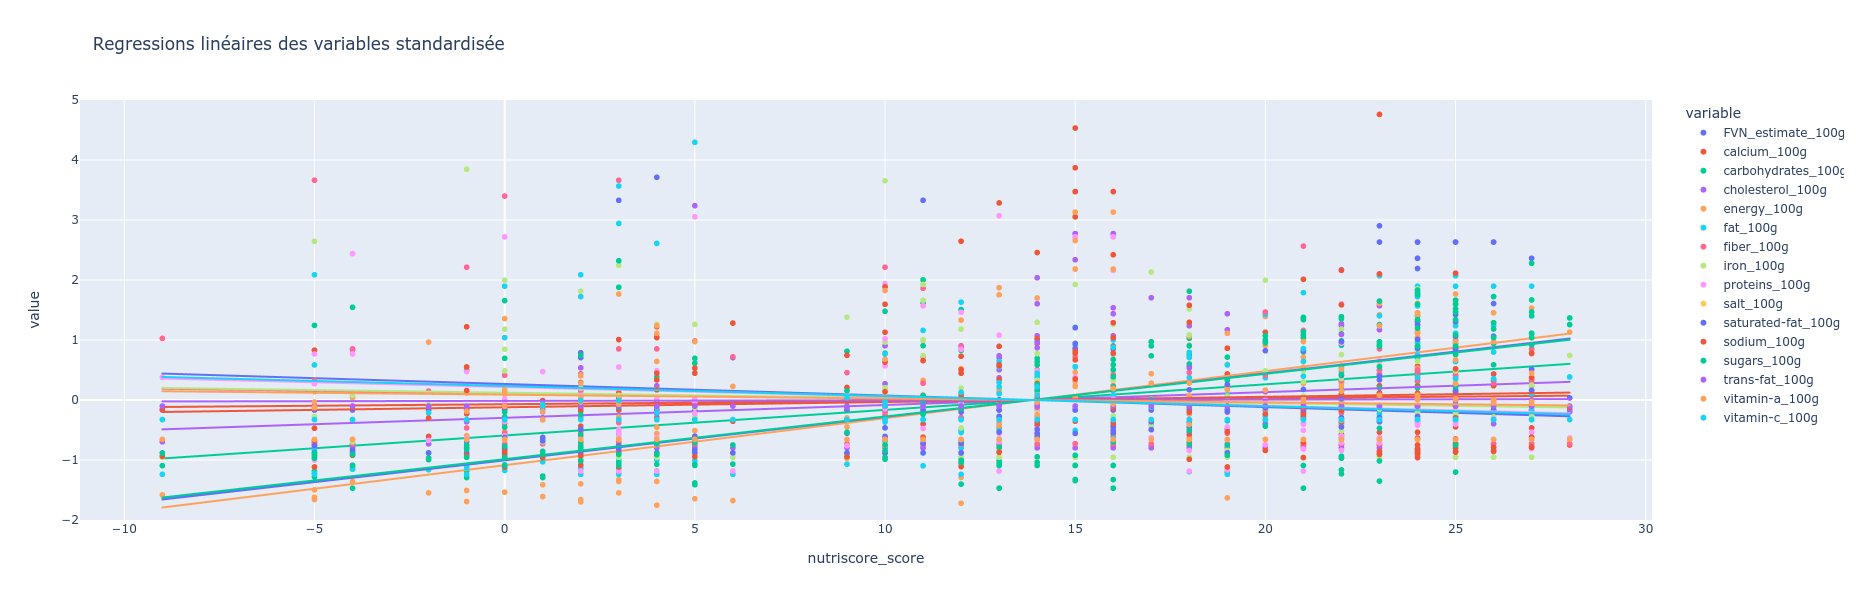

<function __main__.select_reglines(echelle)>

In [41]:
def select_reglines(echelle):
    if echelle == "Standardisée":
        fig = px.scatter(data_sample_std_pd, x="nutriscore_score", y=var_nutri, trendline="ols", height=600, width=1000, range_y=[-2,5], title="Regressions linéaires des variables standardisée")
        fig.show()
        #results = px.get_trendline_results(fig)
    else:
        fig = px.scatter(data_sample, x="nutriscore_score", y=var_nutri, trendline="ols", height=600, width=1000, title="Regressions linéaires des variables non-noralisées")    
        fig.show()
        #results = px.get_trendline_results(fig)

interact(select_reglines, echelle=['Standardisée', 'Originale'])

> En regardant les coéfficients de déterminations R², on constate exactement les même tendances qu'avec les coefficients de Pearson et Spearman. <br>On a un indice moyennement fort pour `saturated-fat_100g`, `energy_100g`, et `sugars_100g`, un indice faible pour `salt_100g`, `FVN_estimate_100g` et `fiber_100g`, un indice quasi nul pour `proteins_100g`.
>
> - `energy_100g`:        **R² = 0.44** *[Pearson = 0.58 & Spearman = 0.60]*
> - `saturated-fat_100g`: **R² = 0.43** *[Pearson = 0.58 & Spearman = 0.64]*
> - `sugars_100g`:        **R² = 0.28** *[Pearson = 0.43 & Spearman = 0.33]*
> - `FVN_estimate_100g`:  **R² = 0.08** *[Pearson = -0.24 & Spearman = -0.19]*
> - `salt_100g`:          **R² = 0.07** *[Pearson = 0.15 & Spearman = 0.34]*
> - `fiber_100g`:         **R² = 0.04** *[Pearson = -0.17 & Spearman = -0.20]*
> - `proteins_100g`:      **R² = 0.01** *[Pearson = 0.08 & Spearman = 0.085]*

> Cette tendance se vérifie avec la plupart des autres colonnes que nous avions remarquées plus haut:
> - `fat_100g`:           **R² = 0.36** *[Pearson = 0.47 & Spearman = 0.59]*
> - `carbohydrates_100g`  **R² = 0.10** *[Pearson = 0.24 & Spearman = 0.18]*
> - `cholesterol_100g`    **R² = 0.08** *[Pearson = 0.19 & Spearman = 0.26]*
> - `sodium_100g`         **R² = 0.07** *[Pearson = 0.16 & Spearman = 0.34]*
> - `calcium_100g`        **R² = 0.03** *[Pearson = 0.14 & Spearman = 0.036]*
> - `vitamin-c_100g`      **R² = 0.02** *[Pearson = -0.13 & Spearman = -0.27]*

> On observant attentivement les lignes de regression lineaires des valeurs standardisées et leurs coéfficients de déterminations R², on constate plusieurs choses intéressantes:
> - `energy_100g` et `saturated-fat_100g` sont très proches.
> - `fiber_100g` et `vitamin-c_100g` sont très proches.
> - `sodium_100g`, `salt_100g` et `carbohydrates_100g` sont très proches.
>
> On peut donc supposer que ces indicateurs nutritionnels ont une égale importance vis à vis du `nutriscore_score`

> Enfin, on note que les lignes de régressions OLS permettent de se faire facilement une **idée** de la relation entre le `nutriscore_score` et donc le `nutriscore_grade`, avec les divers indicateurs nutritionnels.
> <br> Certaines montent avec le score, d'autres baissent avec ce même score, et on peut supposer que c'est effectivement liée, mais nous devrons le vérifier correctement après les imputations.

---

### 4.5 Imputations des valeurs manquantes <a class="anchor" id="clean_imputations"></a>

In [42]:
data_tmp = data_clean.copy()
data_imput_before = data_tmp.copy()

In [43]:
var_nutri = [x for x in data_tmp.columns if x.endswith('_100g')]

#### **a**) Etablissons une baseline pour nos imputations.
Pour ce faire, nous allons simplement imputer en utilisant les moyennes et calculer quelques scores.

In [44]:
data_imput_mean = data_tmp.copy()

In [45]:
true_values_idx = {}
for col in var_nutri:
    true_values_idx[col] = data_tmp.dropna(subset=[col]).sample(frac=0.01, random_state=0).index

In [46]:
for col in var_nutri:
    data_imput_mean.loc[true_values_idx[col] ,col] = None

In [47]:
for col in var_nutri:
    mean = data_imput_mean[col].mean()
    data_imput_mean[col].fillna(mean, inplace=True)

In [48]:
from sklearn.metrics import r2_score, mean_squared_error

In [49]:
def print_scores(dt_true, dt_pred, eval_idx):
    r2_list = []
    rmse_list = []
    for col in var_nutri:
        true_v = dt_true.loc[eval_idx[col]][col]
        pred_v = dt_pred.loc[eval_idx[col]][col]
    
        r2 = r2_score( true_v , pred_v )
        rmse = mean_squared_error( true_v, pred_v, squared=False)
        
        r2_list.append(r2)
        rmse_list.append(rmse)
        
        print(f"{col.rjust(25)}  ==>  R²:{r2:8.2f} | RMSE:{rmse:8.2f}")
    
    r2_mean = sum(r2_list)/len(r2_list)
    rmse_mean = sum(rmse_list)/len(rmse_list)
    print(f"{'-'*115}\n{'MEAN'.rjust(25)}  ==>  R²:{r2_mean:8.2f} | RMSE:{rmse_mean:8.2f}")
        
    return r2_list, rmse_list

In [50]:
_, rmse_list_mean = print_scores(data_tmp, data_imput_mean, true_values_idx)

        FVN_estimate_100g  ==>  R²:   -0.04 | RMSE:   11.33
             calcium_100g  ==>  R²:   -0.01 | RMSE:    0.13
       carbohydrates_100g  ==>  R²:   -0.01 | RMSE:   30.77
         cholesterol_100g  ==>  R²:   -0.02 | RMSE:    0.03
              energy_100g  ==>  R²:   -0.06 | RMSE:  802.31
                 fat_100g  ==>  R²:   -0.00 | RMSE:   14.62
               fiber_100g  ==>  R²:   -0.00 | RMSE:    4.18
                iron_100g  ==>  R²:   -0.00 | RMSE:    0.00
            proteins_100g  ==>  R²:   -0.00 | RMSE:   10.32
                salt_100g  ==>  R²:   -0.01 | RMSE:    2.53
       saturated-fat_100g  ==>  R²:   -0.01 | RMSE:    7.40
              sodium_100g  ==>  R²:   -0.24 | RMSE:    0.49
              sugars_100g  ==>  R²:   -0.01 | RMSE:   17.94
           trans-fat_100g  ==>  R²:    0.00 | RMSE:    0.06
           vitamin-a_100g  ==>  R²:   -0.02 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:   -0.87 | RMSE:    0.00
----------------------------------------

#### **b**) Imputation par IterativeImputer

Dans un IterativeImputer, les colonnes sont remplies par ordre croissant; de celles qui ont le moins de valeurs manquantes à celles qui en ont le plus. Il est donc inutile d'utiliser une autre méthode au préalable pour compléter les colonnes les mieux pourvues avant d'utiliser un IterativeImputer sur le reste. Nous allons cependant définir des valeurs min et max pour l'imputation qui correspondent aux valeurs métiers établies plus tôt.

In [51]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [52]:
data_imput_iter = data_tmp.copy()

In [53]:
for col in var_nutri:
    data_imput_iter.loc[true_values_idx[col] ,col] = None

In [54]:
X = data_imput_iter[var_nutri]
# y = data_input_iter['nutriscore_score']

In [55]:
max_values_imput = [100.0]*len(var_nutri)
for i, col in enumerate(var_nutri):
    if(col in max_values):
        max_values_imput[i] = max_values[col]

In [56]:
imputer = IterativeImputer(
    imputation_order='ascending', 
    random_state=0, 
    min_value=0, 
    max_value=max_values_imput
)
Xtrans = imputer.fit_transform(X)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P3/venvP3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [57]:
Xtrans = pd.DataFrame(Xtrans, columns=var_nutri, index=data_tmp.index)

In [58]:
data_imput_iter_pre = data_imput_iter.copy()

In [59]:
data_imput_iter[var_nutri] = Xtrans

In [60]:
_, rmse_list_iter = print_scores(data_tmp, data_imput_iter, true_values_idx)

        FVN_estimate_100g  ==>  R²:    0.17 | RMSE:   10.12
             calcium_100g  ==>  R²:    0.20 | RMSE:    0.12
       carbohydrates_100g  ==>  R²:    0.82 | RMSE:   13.03
         cholesterol_100g  ==>  R²:   -0.85 | RMSE:    0.04
              energy_100g  ==>  R²:    0.55 | RMSE:  523.48
                 fat_100g  ==>  R²:    0.82 | RMSE:    6.26
               fiber_100g  ==>  R²:    0.11 | RMSE:    3.94
                iron_100g  ==>  R²:    0.51 | RMSE:    0.00
            proteins_100g  ==>  R²:    0.54 | RMSE:    7.01
                salt_100g  ==>  R²:    0.99 | RMSE:    0.30
       saturated-fat_100g  ==>  R²:    0.65 | RMSE:    4.34
              sodium_100g  ==>  R²:    0.93 | RMSE:    0.12
              sugars_100g  ==>  R²:    0.06 | RMSE:   17.28
           trans-fat_100g  ==>  R²:    0.00 | RMSE:    0.06
           vitamin-a_100g  ==>  R²:    0.21 | RMSE:    0.00
           vitamin-c_100g  ==>  R²:    0.21 | RMSE:    0.00
----------------------------------------

#### **c**) Comparons les scores obtenus avec l'IterativeImputer et les imputations par les moyennes

In [61]:
best_is_mean = []
for i in range(len(rmse_list_iter)):
    diff = rmse_list_iter[i] - rmse_list_mean[i]
    
    if diff > 0:
        best_is_mean.append(True)
        best = 'Mean'
    else:
        best_is_mean.append(False)
        best = 'IterativeImputer'
        
    print(f"{var_nutri[i].rjust(25)} | diff={diff:8.3f} | Best method: {best}")

        FVN_estimate_100g | diff=  -1.218 | Best method: IterativeImputer
             calcium_100g | diff=  -0.014 | Best method: IterativeImputer
       carbohydrates_100g | diff= -17.737 | Best method: IterativeImputer
         cholesterol_100g | diff=   0.011 | Best method: Mean
              energy_100g | diff=-278.830 | Best method: IterativeImputer
                 fat_100g | diff=  -8.365 | Best method: IterativeImputer
               fiber_100g | diff=  -0.234 | Best method: IterativeImputer
                iron_100g | diff=  -0.000 | Best method: IterativeImputer
            proteins_100g | diff=  -3.311 | Best method: IterativeImputer
                salt_100g | diff=  -2.230 | Best method: IterativeImputer
       saturated-fat_100g | diff=  -3.059 | Best method: IterativeImputer
              sodium_100g | diff=  -0.374 | Best method: IterativeImputer
              sugars_100g | diff=  -0.667 | Best method: IterativeImputer
           trans-fat_100g | diff=   0.001 | Best m

> On constate que l'IterativeImputer a obtenu de meilleurs scores RMSE que l'imputation par la moyenne, pour toutes les colonnes.

In [62]:
# Remettons les valeurs originales que nous avions supprimées et imputées pour les évaluations

data_imput = data_imput_iter.copy()
for col in var_nutri:
    data_imput.loc[true_values_idx[col], col] = data_clean.loc[true_values_idx[col]][col]

#### **d**) Vérifions la distribution des variables numériques avant et après les imputation

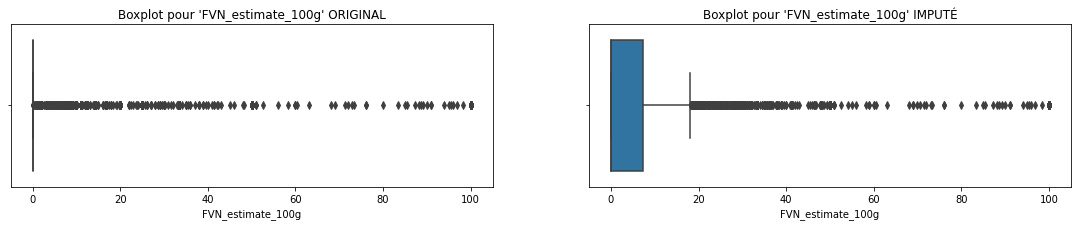

<function __main__.select_distrib(colonne)>

In [63]:
data_distrib11 = data_tmp.copy()
data_distrib12 = data_imput.copy()

def select_distrib(colonne):
    fig = plt.figure(figsize=(19,3))

    ax = plt.subplot(1, 2, 1)
    sns.boxplot(x=data_distrib11[colonne][data_distrib11[colonne].notnull()])
    plt.title(f"Boxplot pour '{colonne}' ORIGINAL")
    
    ax = plt.subplot(1, 2, 2)
    sns.boxplot(x=data_distrib12[colonne][data_distrib12[colonne].notnull()])
    plt.title(f"Boxplot pour '{colonne}' IMPUTÉ")
    plt.show()

interact(select_distrib, colonne=var_nutri)

> Aucune des variables ne présente de différence significative.

#### **e**) Appliquons les imputation sur le jeu de données et vérifions les différences de remplissage avant/après imputation

In [64]:
data_imput_after = data_imput.copy()

           COLONNE |   LIGNES VIDES  |     REMPLISSAGE 
----------------------------------------------------------
 FVN_estimate_100g |               0 |          100.00%
      calcium_100g |               0 |          100.00%
carbohydrates_100g |               0 |          100.00%
  cholesterol_100g |               0 |          100.00%
       energy_100g |               0 |          100.00%
          fat_100g |               0 |          100.00%
        fiber_100g |               0 |          100.00%
         iron_100g |               0 |          100.00%
     proteins_100g |               0 |          100.00%
         salt_100g |               0 |          100.00%
saturated-fat_100g |               0 |          100.00%
       sodium_100g |               0 |          100.00%
       sugars_100g |               0 |          100.00%
    trans-fat_100g |               0 |          100.00%
    vitamin-a_100g |               0 |          100.00%
    vitamin-c_100g |               0 |       

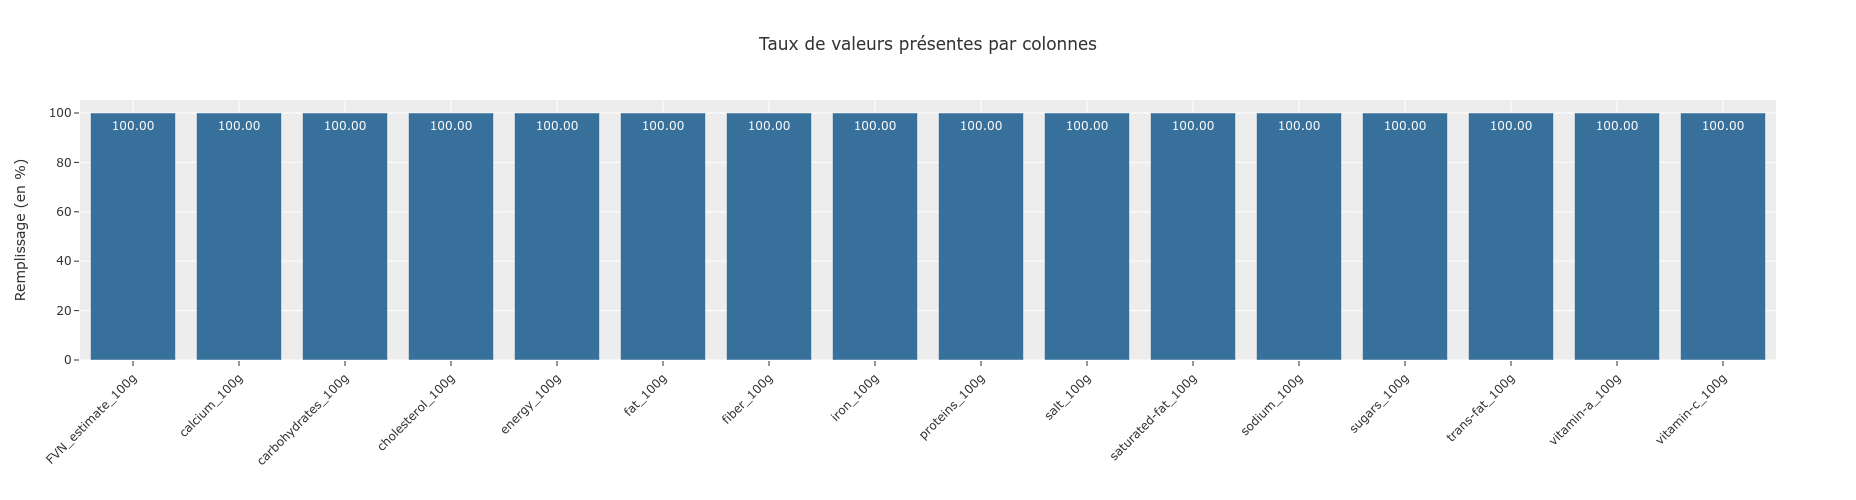

<function __main__.select_imput1(stade)>

In [65]:
def select_imput1(stade):
    
    if stade == 'AVANT':
        fill_ratio = print_fill_rate(data_imput_before, var_nutri)
    else:
        fill_ratio = print_fill_rate(data_imput_after, var_nutri)
        
    #print(fill_ratio)
    fill_ratio_df = pd.DataFrame(fill_ratio, columns=["fill_rate"])

    fig = px.bar(fill_ratio_df, y="fill_rate", 
             width=1000,
             height=500,
             color='fill_rate', 
             title="Taux de valeurs présentes par colonnes",
             labels={
                "fill_rate": "Remplissage (en %)",
                "index": "",
                },
             template='ggplot2',
             text=[f"{x:.2f}" for x in fill_ratio_df.fill_rate],
            )

    fig.update_coloraxes(showscale=False)
    fig.update_xaxes(tickangle = -45)
    fig.show()

interact(select_imput1, stade=['APRES', 'AVANT'])

In [66]:
data_clean = data_imput.copy()

---

### 4.6 Suppression des lignes dont les valeurs nutritionnelles ne sont pas logiques <a class="anchor" id="clean_logic"></a>

Certaines colonnes du jeu de données, sont en fait des sous catégories d'autres colonnes. Par exemple `fat_100g` contient également `trans-fat_100g`, `saturated-fat_100g` et `cholesterol_100g`. De même `carbohydrates_100g` contient `sugars_100g` et `salt_100g` contient `sodium_100g`. Sur la base de ces informations, vérifions si les colonnes des `_100g` ne dépassent pas certaines limites logiques.

In [67]:
data_check = data_clean.copy()

#### **a**) Supprimons les lignes dont le taux de `sugars_100g` dépasse celui des `carbohydrates_100g` *(avec une marge de tolérence)*

In [68]:
check_idx = data_check[(data_check.sugars_100g - data_check.carbohydrates_100g > 1) & (data_check.carbohydrates_100g > 0)].index

In [69]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 8539 lignes (12 lignes de moins)


#### **b**) Supprimons les lignes dont le taux de `saturated-fat_100g` + `trans-fat_100g` + `cholesterol_100g` dépasse celui des `fat_100g` *(avec une marge de tolérence)*

In [70]:
check_idx = data_check[
    (
        data_check['saturated-fat_100g'] + \
        data_check['trans-fat_100g'] + \
        data_check['cholesterol_100g'] -\
        data_check['fat_100g'] > 1 
    ) & (data_check['fat_100g'] > 0)
    ].index

In [71]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 8492 lignes (47 lignes de moins)


#### **c**) Supprimons les lignes dont le taux de `sodium_100g` x 2.45, dépasse celui du `salt_100g` *(avec une marge de tolérence)*

In [72]:
check_idx = data_check[(data_check.sodium_100g * 2.45 - data_check.salt_100g > 0) & (data_check.salt_100g > 0)].index

In [73]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 8492 lignes (0 lignes de moins)


#### **d**) Supprimons les lignes dont la sommes des principales catégories dépasse les 100g *(avec une marge de tolérence)*

In [74]:
check_idx = data_check[
    (
        data_check['carbohydrates_100g'] + \
        data_check['fat_100g'] + \
        data_check['proteins_100g'] + \
        data_check['salt_100g'] + \
        data_check['fiber_100g'] + \
        data_check['calcium_100g'] + \
        data_check['vitamin-a_100g'] + \
        data_check['vitamin-c_100g'] + \
        data_check['iron_100g'] - 100 > 1
    )
    ].index

In [75]:
data_check.drop(check_idx, inplace=True)
print_current_size(data_check)

A ce stade le jeu de données contient 7680 lignes (812 lignes de moins)


In [76]:
data_clean = data_check.copy()

---
---

# 5. Démarche méthodologique d'analyse de données <a class="anchor" id="P05"></a>

### 5.1 Analyses univariées des variables <a class="anchor" id="analysis_univariate"></a>

Le but d'une analyse univariée est de décrire les données pour en découvrir les caractéristiques et mieux les comprendre. <br>Pour ce faire, on examine la moyenne, le mode, la médiane, l'écart type, la dispersion, etc. par le biais d'histogrammes, de tableaux de distribution de fréquence, de diagrammes à barres, ou autres.

#### Explorons les différentes variables sélectionnées à l'aide du selecteur ci-dessous

In [77]:
vars_quantitatives = data_nutri.select_dtypes(include=np.number).columns
vars_qualitatives = data_nutri.select_dtypes(exclude=np.number).columns

In [78]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm #, uniform

In [297]:
# Définissons une fonction permettant d'explorer les colonnes numériques

def explore_quantitative(data, col_name):
    dt = data[col_name]
    #print(dt.describe())
    
    print('\n')
    
    fig = plt.figure(figsize =(15, 8))
    
    ax = plt.subplot(2, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")
    
    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")
    
    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot pour {col_name}")
    qqplot(data_clean[data_clean[col].notnull()][col], norm, fit=True, line="45", ax=ax)
    
    ### Missing
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null
     
    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Répartition entre produits avec ou sans '{col_name}'")
    plt.legend([f"Produits sans '{col_name}'", f"Produits avec '{col_name}'"], loc='lower center', bbox_to_anchor=(0, 0))
    
    fig.tight_layout()
    plt.show()
    
    print(f"Il manque {total_size_null} sur {total_size} dans la colonne '{col_name}' ({percent_v:.2f}%)")
    
    print(f"\n----- NOTES sur la colonne '{col_name}' ----\n")
    
    
    display(HTML("""On note que cette variable présente de nombreuses valeurs atypiques.<br>
Cependant, toutes les valeurs sont strictement contenues dans un intervalle légitime définit lorsque nous avons supprimés les valeurs aberrantes.<br><br>

Les QQ-plot et Density plot permettent également de voir que cette variable n'a pas une distribution <i>normale</i>.<br><br>

<b>RECOMMANDATIONS:</b> faire une analyse multivariée pour vérifier l'intérêt de la colonne pour le modèle prédictif.<br><br>"""))

In [244]:
# Définissons une fonction permettant d'afficher la répartition des données (sans pie-chart)

def display_fraction(data, col_name, title, ylabel="Remplissage (en %)", showscale=True, showtext=True):
    dt = data[col_name]

    fig = px.bar(dt, y=col_name, 
             width=900,
             height=500,
             color=col_name, 
             title=title,
             labels={
                "fill_rate": ylabel,
                "index": "",
                },
             text_auto=showtext,
             template='ggplot2',
             #hover_data={'Fraction':':.2f'},
            )
    fig.update_coloraxes(showscale=showscale)
    fig.update_xaxes(tickangle = -45)
    fig.show()

In [260]:
# Définissons une finction permettant d'afficher quelques informations sur le remplissage d'UNE colonne

def show_missing(data, col_name, title=True):
    
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null
    
    print(f"Il manque {total_size_null} valeurs sur {total_size} dans la colonne '{col_name}' ({percent_v:.2f}%)")
    
    fig = plt.figure(figsize=[15,5])

    plt.pie(list([total_size_null,total_size_nonull]), 
        labels=["", ""],
        autopct=lambda x: f"{x:.2f}%", shadow=False)
    if(title):
        plt.title(f"Répartition entre produits avec ou sans '{col_name}'")
    plt.legend([f"Produits sans '{col_name}'", f"Produits avec '{col_name}'"], loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [263]:
##################################################################################################################################

In [267]:
from IPython.display import display, HTML

In [293]:
def explore_product_name(data):
    
    #### Regardons la répartition de ces valeurs
    
    print(f"----- Répartition des noms de produits -----")
    
    vcount = data['product_name'].value_counts(dropna=True)
    select_count = pd.DataFrame(vcount)

    # On calcul le pourcentage
    #select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'product_name':'Quantité'}, inplace=True)

    # On selectionne les 25 premiers
    select_count = select_count[:25]

    display_fraction(select_count, 'Quantité', 
                 "Top 25 des noms de produits les plus communs", 
                 showscale=True, showtext=True)
    
    #### Combien de produits ont un nom unique ? 
    
    unique_v = data['product_name'].isin(vcount.index[vcount<=1.0]).sum()
    percent_v = 100/data.shape[0]*unique_v

    print(f"Il y a {unique_v} noms de produits ne correspondant qu'à un seul produit ({percent_v:.2f}%)")
    
    #### Valeurs manquantes
    
    print(f"\n----- Répartition entre produits avec ou sans 'product_name' ----\n")
    show_missing(data, 'code')
    
    #### Conclusion
    
    print(f"\n----- NOTES sur la colonne 'nutriscore_grade' ----\n")
    display(HTML("""Si la majorité des produits sont uniques (60.05%), de nombreux produits sont malgré tout associés au même nom.<br>
Ce n'est pas vraiment étonnant, car on peut avoir des noms très générique <i>(par exemple le mode est ici "Ice cream" avec 717 instances)</i> avec des valeurs nutritionnelles différentes.<br>
On note d'ailleurs que malgré le nettoyage fait au préalable, il reste environ 8600 produits sans nom...<br><br>

<b>RECOMMANDATIONS:</b> la colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.<br><br>"""))

In [291]:
def explore_pnns_groups_2(data):
    
    #### Regardons la répartition de ces valeurs
    
    print(f"----- Répartition des catégories pnns_groups_2 -----")
    
    vcount = data['pnns_groups_2'].value_counts(dropna=True)
    select_count = pd.DataFrame(data['pnns_groups_2'].value_counts(dropna=True))

    # On calcul le pourcentage
    select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'pnns_groups_2':'Pourcentage'}, inplace=True)

    # On selectionne les 25 premiers
    select_count = select_count[:25]

    display_fraction(select_count,
                     'Pourcentage', "Repartition (en % des non-nulls) de produits par catégories principales (Top 25 uniquement & hors None)", 
                     showscale=True, showtext=True)
        
    #### Valeurs manquantes
    
    print(f"\n----- Répartition entre produits avec ou sans 'pnns_groups_2' ----\n")
    show_missing(data, 'pnns_groups_2')
    
    #### Conclusion
    
    print(f"\n----- NOTES sur la colonne 'nutriscore_grade' ----\n")
    display(HTML("""Les sucreries (Sweets), biscuits et gateaux (Biscuits and cakes) prennent une place importante.<br><br>

Les produits bruts comme la viande (Meat), le poisson (Fish and seafood), les légumes (Vegetables) ou les fruits (Fruits) sont moins bien représentés.<br><br>

<b>RECOMMANDATIONS:</b> on peut essayer d'imputer cette colonne avec un KNN.<br><br>"""))

In [292]:
def explore_nutriscore_grade(data):
    
    #### Regardons la répartition de ces valeurs
    
    print(f"----- Répartition des nutrigrades -----")
    
    vcount = data['nutriscore_grade'].value_counts(dropna=True).sort_index()
    select_count = pd.DataFrame(vcount)

    # On calcul le pourcentage
    select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'nutriscore_grade':'Pourcentage'}, inplace=True)

    display_fraction(select_count, 'Pourcentage', 
                 "Repartition des Nutri-grades (sur les valeurs non-nulles)", 
                 showscale=True, showtext=True)
    
    #### Valeurs manquantes
    
    print(f"\n----- Répartition entre produits avec ou sans 'nutriscore_grade' ----\n")
    show_missing(data, 'nutriscore_grade')
    
    #### Conclusion
    
    print(f"\n----- NOTES sur la colonne 'nutriscore_grade' ----\n")
    display(HTML("""Si la majorité des grades ne sont pas renseignés (63.66%), on constate quand ils le sont beaucoup de D (30.5%), peu de B (13.8%) et modèrement du reste (A: 15.9%, C: 21.4%, E: 18.4%).<br><br>

Il est très probable que l'on retrouve une répartition similaire dans la colonne nutriscore_score (c'est juste après).<br><br>

<b>RECOMMANDATIONS:</b> explorer la relation entre nutriscore_score et nutriscore_grade lors des analyses multivariées.<br><br>"""))

In [287]:
def explore_code(data):
    
    #### Regardons la répartition de ces valeurs
    
    print(f"----- Répartition des code-barres selon leur taille -----")
    
    vcount = data['code'].str.len().value_counts(dropna=True)
    select_count = pd.DataFrame(vcount)

    # On calcul le pourcentage
    select_count = np.round(select_count / select_count.sum() * 100.0, 1)
    select_count.rename(columns={'code':'Quantité'}, inplace=True)

    # On selectionne les 25 premiers
    select_count = select_count[:20]

    display_fraction(select_count, 'Quantité', 
                 None, 
                 showscale=True, showtext=True)

    #### Regardons le nombre de code-barres entièrement composés de chiffres *(donc sans lettres)*
        
    digit_v = data_clean['code'].str.isdigit().sum()
    percent_v = 100/data_clean.shape[0]*digit_v

    print(f"Il y a {digit_v} code-barres entièrement composés de chiffres ({percent_v:.2f}%)")
    
    #### Valeurs manquantes
    
    print(f"\n----- Répartition entre produits avec ou sans 'code' ----\n")
    show_missing(data, 'product_name', False)
    
    #### Conclusion
    print(f"\n----- NOTES sur la colonne 'code' ----\n")
    display(HTML("""On a 1 code-barre unique pour chaque ligne du jeu de données <i>(chaque code-barre est unique et aucun produit n'a pas de code-barre)</i>.<br><br>

Le format bien que toujours composé de chiffres, n'est pas un format unique (on trouve des code de longueur 1 à 56). Cependant on constate que la grande majorité des `codes` sont au format EAN-13 (93.1%) puis EAN-8 (5.1%).<br><br>

Nous avions gardé cette colonne pour aider à la suppression des doublons et c'est chose faite, elle ne présente donc plus d'autre intérêt que de rechercher un produit via son code-barre.<br>
La colonne n'est d'aucune utilité pour le modèle prédictif, mais elle peut être utile pour retrouver un produit.<br><br>"""))

In [288]:
##################################################################################################################################

In [289]:
data_clean['nutriscore_grade'] = data_clean['nutriscore_grade'].str.upper()

----- ANALYSE UNIVARIÉE de "code" -----

count                     7680
unique                    7680
top       00000000000003429145
freq                         1
Name: code, dtype: object


----- Répartition des code-barres selon leur taille -----


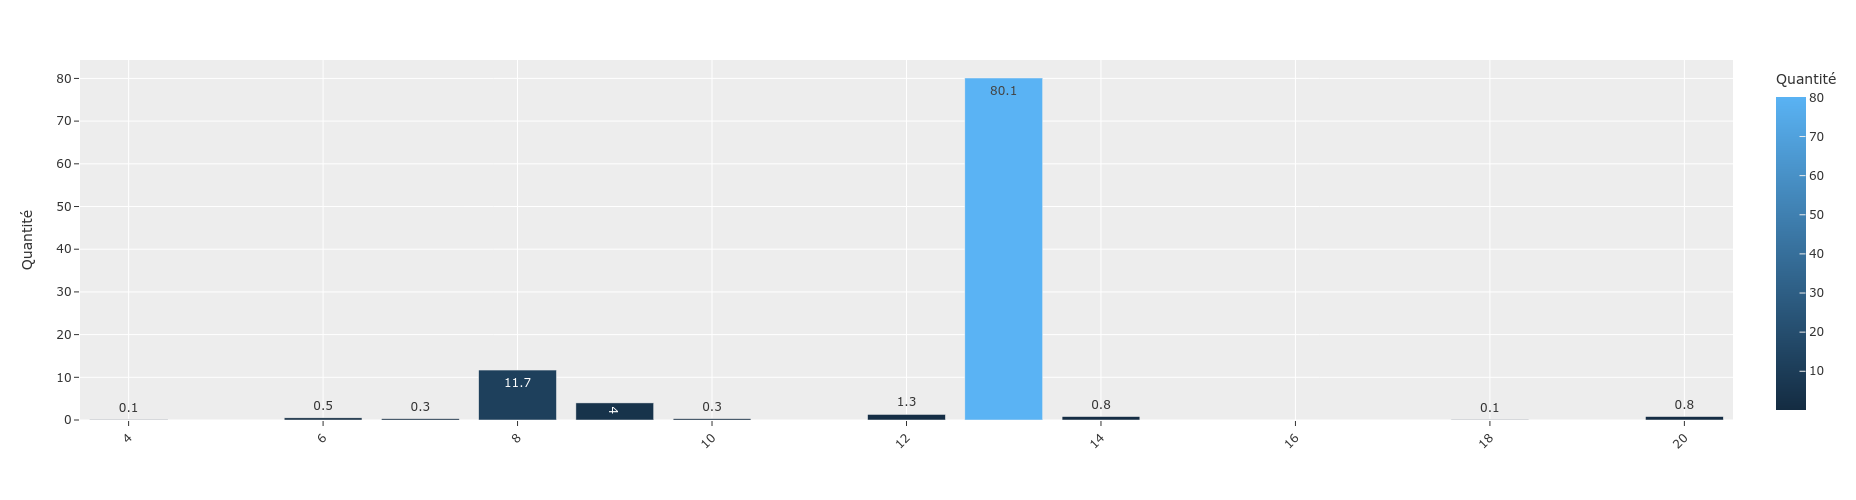

Il y a 7680 code-barres entièrement composés de chiffres (100.00%)

----- Répartition entre produits avec ou sans 'code' ----

Il manque 1 valeurs sur 768 dans la colonne 'product_name' (0.13%)


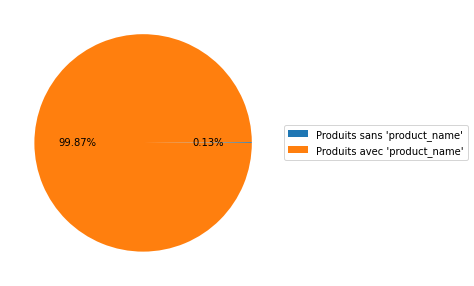


----- NOTES sur la colonne 'code' ----



<function __main__.select_var(colonne)>

In [295]:
def select_var(colonne):
    
    data_sample = data_clean.sample(frac=0.1)
    
    print(f'----- ANALYSE UNIVARIÉE de "{colonne}" -----\n',data_clean[colonne].describe(),'\n', sep='\n')
    
    # graphiques pour variables quantitatives
    if colonne in data_clean.select_dtypes(include='number'):
        explore_quantitative(data_sample, colonne)
    else:
        
        if colonne == 'code':
            explore_code(data_sample)
        elif colonne == 'product_name':
            explore_product_name(data_sample)
        elif colonne == 'pnns_groups_2':
            explore_pnns_groups_2(data_sample)
        elif colonne == 'nutriscore_grade':
            explore_nutriscore_grade(data_sample)
        
    #return col
    
interact(select_var, colonne=data_clean.columns)

---

### 5.2 Analyses multivariées <a class="anchor" id="analysis_multivariate"></a>

Les analyses multivariées ont pour vocation de mettre en évidence des informations sur les relations entre variables. Mais sans objectif on peut croiser beaucoup de données sans vraiment savoir ce que l'on cherche...

On va vu que la [documentation du nutriscore](https://www.santepubliquefrance.fr/content/download/150262/file/QR_scientifique_technique_310322.pdf) *(page 30)* nous permettant de déterminer les éléments favorables ou défavorables au calcul de ce grade.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.


#### Hypothèse
> Nous allons donc **vérifier par des analyses bivariées et multivariées, si des colonnes pouvant correspondre aux éléments favorables ou défavorables pour `nutriscore_score` et `nutriscore_grade` le sont effectivement**.

> Voici donc les objectifs pour lesquels il serait utile d'avoir des informations:
> 1. Vérifier la relation entre `nutriscore_score` et les divers indicateurs des nutriments.
> 2. Vérifier la relation entre `nutriscore_grade` et les divers indicateurs des nutriments.
> 3. Vérifier la relation entre `nutriscore_score` et `nutriscore_grade`
> 4. Vérifier la relation entre `nutriscore_grade` et `pnns_groups_2` *(ça ne sert pas l'hypothèse, mais ça pourrait être intéressant)*

---

#### Commençons par (re)vérifier les corrélations entre les variables `numériques` après imputations & nettoyage. <a class="anchor" id="P03_correlation_num"></a>

Il existe plusieurs types de relations entre des variables numériques. Par exemple les rélations linéaires ou encore les relations monotones.
- Dans une relation linéaire, les variables se déplacent dans la même direction à un rythme constant.
- Dans une relation monotone, les variables ont tendance à se déplacer dans la même direction relative, mais pas nécessairement à un rythme constant.


Pour ces deux mesures les valeurs peuvent aller de -1 à 1 (inclus):
- -1 indique une relation forte dans le sens inverse (corrélation négative)
- +1 indique une relation forte dans le même sens (corrélation positive)
- 0  indique qu'il n'y a pas de relation.

Calculons donc les deux pour voir si quelque chose s'en dégage.

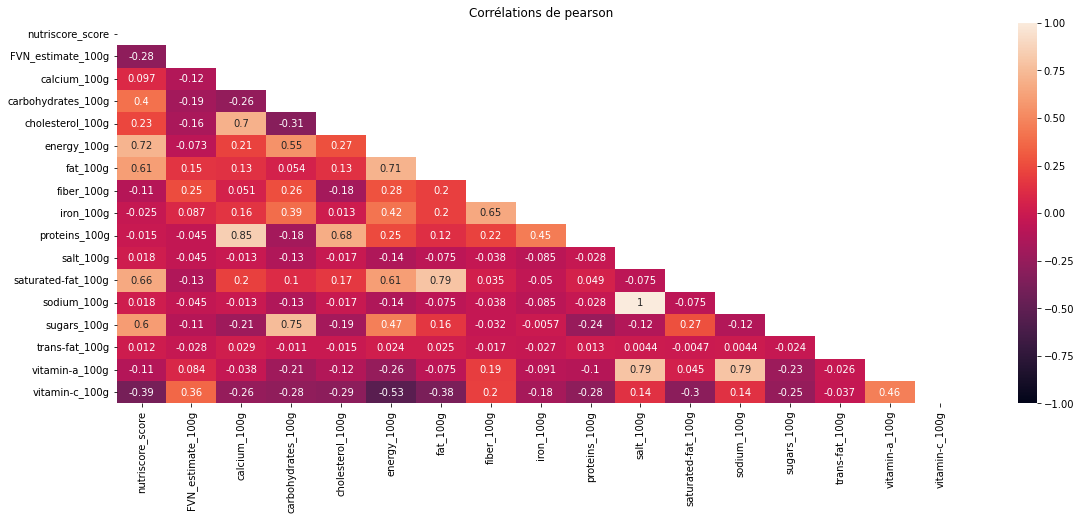

<function __main__.show_correlation2(correlation)>

In [88]:
data_corr_2 = data_clean.sample(frac=0.1).copy()

def show_correlation2(correlation):
    
    fig = plt.figure(figsize=(19,7))
    corr= data_corr_2.corr(method=correlation)
    matrix = np.triu(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
    ax.set_title(f'Corrélations de {correlation}')
    #ax.legend()
    
    plt.show() 

interact(show_correlation2, correlation=["pearson", "spearman"])

> Nous avions [déjà vérifié ces indices](#clean_correlations) de corrélation avant le nettoyage des données. Mais on constate que le nettoyage a légèrement modifié ces données.
>
> - La plus part des indices restent sensiblement les même avec une lègère augmentation ou diminution.
> - On note cependant l'apparition d'une forte corrélation entre le `calcium_100g` et le `cholesterol_100g`.
> - La colonne `vitamin-c_100g` qui étaient corrélée très peu de colonnes l'est à présent avec la plupart.
> - `fiber_100g` et `iron_100g`, `proteins_100g` et `calcium_100g` ou encore `proteins_100g` et `cholesterol` qui étaient modèrement corrélées, le sont à présent fortement.
>
> **Dans l'ensemble on note qu'après le nettoyage les corrélations sont plus marquées qu'avant.**

---

#### Puis vérifions les indices de corrélation entre les variables `numériques` et `nominales`. <a class="anchor" id="P03_correlation_num_nom"></a>
                                                                                   
Pour permettre de vérifier simplement la corrélation entre les variables numériques et les variables nominales, nous allons utiliser un LabelEncoder sur les colonnes nominales qui nous intéressent puis calculer à nouveau les corrélations linéaires et monotones.<br>(On pourrait aussi calculer $\eta^2$ à partir d'une ANOVA)

In [89]:
data_corr = data_clean.copy()

In [90]:
from sklearn.preprocessing import LabelEncoder

In [91]:
cats = ['pnns_groups_2', 'nutriscore_grade']#, 'nova_group']

for cat in cats:
    encoder=LabelEncoder()
    encoder.fit(data_corr[cat])
    data_corr[f"{cat}_enc"]=encoder.transform(data_corr[cat])

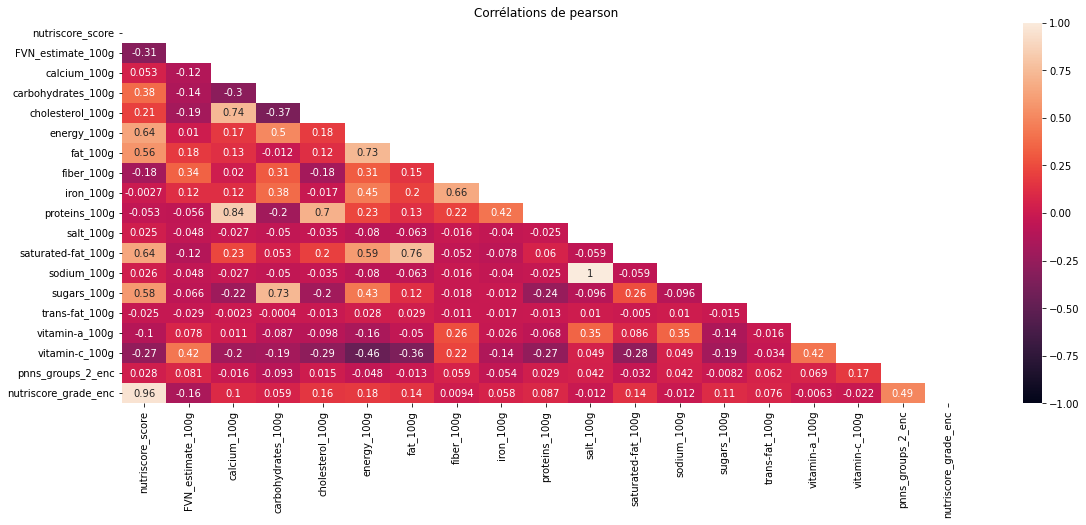

<function __main__.show_correlation3(correlation)>

In [92]:
data_corr_3 = data_corr.sample(frac=0.1).copy()

def show_correlation3(correlation):
    
    fig = plt.figure(figsize=(19,7))
    corr= data_corr_3.corr(method=correlation)
    matrix = np.triu(corr)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix)
    ax.set_title(f'Corrélations de {correlation}')
    #ax.legend()
    
    plt.show() 

interact(show_correlation3, correlation=["pearson", "spearman"])

> Comme attendu on constate une forte corrélation entre le `nutriscore_score` et `nutriscore_grade_enc`.
>
> On constate également plusieurs corrélations faibles entre `nutriscore_grade_enc` et les divers indicateurs nutritionnels, mais elles sont nettement moins prononcées qu'avec `nutriscore_score`.
>
> En revanche, `nutriscore_grade_enc` semble moyennement corrélée avec les catégories de produits `pnns_groups_2`.
>
> Enfin, si les deux variables nominales encodées sont modérement corrélées entre elles *(on va le vérifier avec un test V de Cramer)*, on note que `pnns_groups_2_enc` ne semble pas particulièrement sensible aux variables des nutriments.

---

#### Enfin vérifions les indices de corrélation entre les variables `nominales`. <a class="anchor" id="P03_correlation_nom"></a>

Pour ce faire, nous allons utiliser le test V de Cramer.<br>
C'est une mesure d'association entre deux variables nominales, qui est basée sur le Chi-squared de Pearson.<br>
Elle donne une valeur comprise entre 0 et +1 (inclus)
- 0 : il n'y a visiblement aucune relation entre les variables.
- 1 : il y a une relation parfaite entre les variables (on ne peut atteindre 1 que lorsque chaque variable est complètement déterminée par l'autre).

In [298]:
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

vars_ = ['nutriscore_grade', 'pnns_groups_2']

corr = []
for v1 in vars_:
    corr2 = []
    for v2 in vars_:
        confusion_matrix = pd.crosstab(data[v1], data[v2])
        cramer_score = cramers_v(confusion_matrix.values)
        #print(f"{v1} / {v2} -> {cramer_score}")
        corr2.append(cramer_score)
    corr.append(corr2)
    
corr = pd.DataFrame(corr)
corr.index = corr.columns = vars_

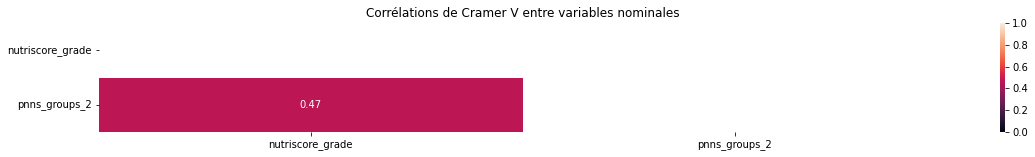

In [301]:
fig = plt.figure(figsize=(19,2))

matrix = np.triu(corr)
ax = sns.heatmap(corr, vmin=0, vmax=1, annot=True, mask=matrix)
ax.set_title('Corrélations de Cramer V entre variables nominales')

plt.show()

> Comme nous l'avions déjà constatés un peu plus haut avec les corrélations de Pearson et Spearma en encodant ces variables, le `nutriscore_grade` est modèrement corrélé aux catégories de produits `pnns_groups_2`.

---

### Objectif 1 : Vérifions les relations entre `nutriscore_score` et les variables des nutriments
Pour ce faire, nous allons utiliser des `régressions linéaires` et leur `coéfficients de détermination R²`

Les valeurs du coéfficient de détermination R², peuvent aller de 0 à 1 (inclus):
- 1 indique une relation forte.
- 0  indique qu'il n'y a pas de relation.


In [95]:
var_nutri = [x for x in data_clean.columns if x.endswith('_100g')]
data_sample2 = data_clean.sample(frac=0.1, random_state=0)
data_sample2.dropna(inplace=True)
data_sample2.reset_index(inplace=True, drop=True)

In [96]:
data_sample_std2 = StandardScaler().fit_transform(data_sample2[var_nutri])
data_sample_std_pd2 = pd.DataFrame(data_sample_std2, columns=var_nutri)
data_sample_std_pd2['nutriscore_score'] = data_sample2['nutriscore_score']

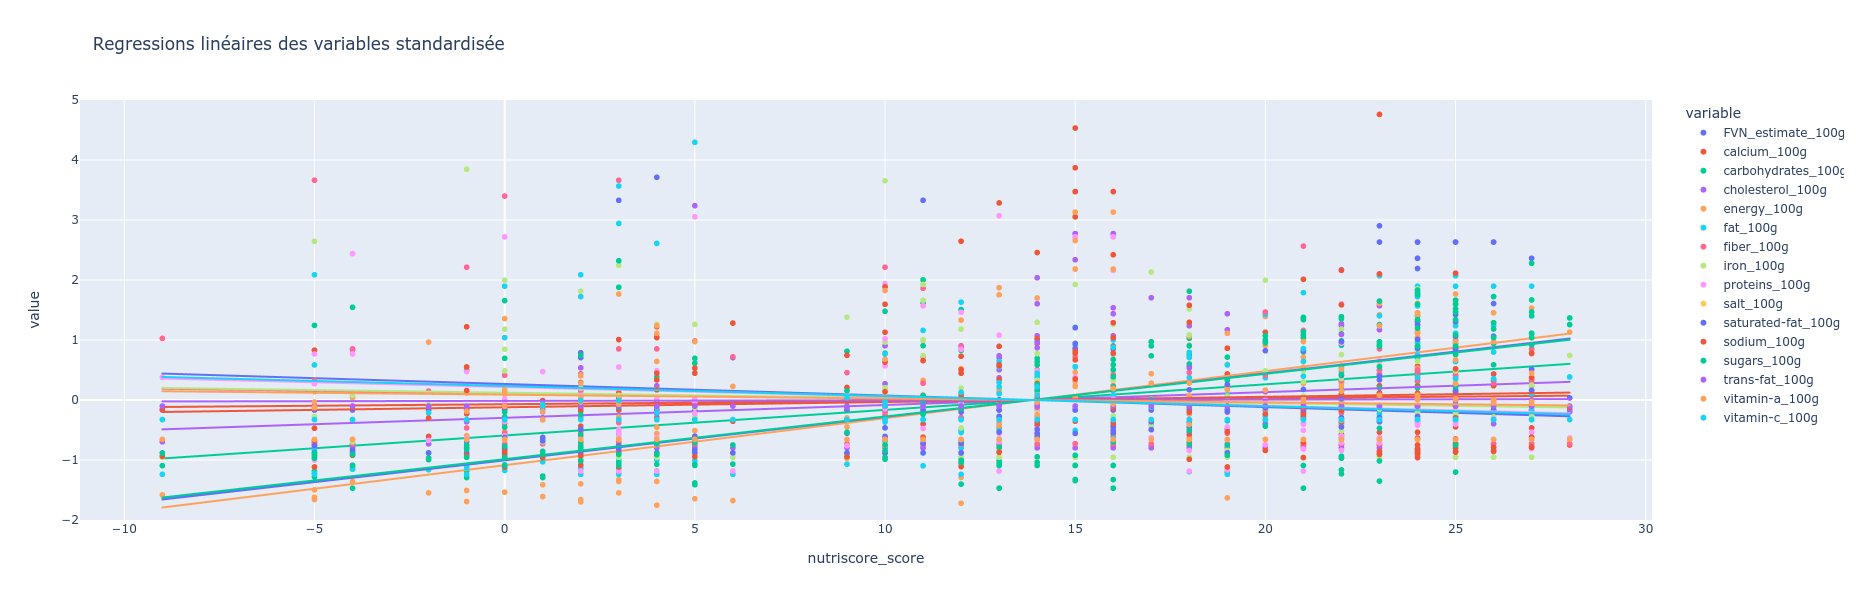

<function __main__.select_reglines(echelle)>

In [97]:
def select_reglines(echelle):
    if echelle == "Standardisée":
        fig = px.scatter(data_sample_std_pd, x="nutriscore_score", y=var_nutri, trendline="ols", height=600, width=1000, range_y=[-2,5], title="Regressions linéaires des variables standardisée")
        fig.show()
        #results = px.get_trendline_results(fig)
    else:
        fig = px.scatter(data_sample, x="nutriscore_score", y=var_nutri, trendline="ols", height=600, width=1000, title="Regressions linéaires des variables non-noralisées")    
        fig.show()
        #results = px.get_trendline_results(fig)

interact(select_reglines, echelle=['Standardisée', 'Originale'])

> On constate que **les coéfficients de détermination R² se sont globalement affaiblis** par rapport à la [première exploration](#clean_linear) faite avant le nettoyage et les imputations, mais **dans l'ensemble les tendances sont les mêmes**.
>
> - `energy_100g`:        son **R² baisse** de 0.44 à **0.35**
> - `saturated-fat_100g`: son **R² baisse** de 0.43 à **0.35**
> - `sugars_100g`:        son **R² baisse** de 0.28 à **0.22**
> - `FVN_estimate_100g`:  son **R² baisse** de 0.08 à **0.06**
> - `salt_100g`:          son **R² baisse** de 0.07 à **0.04**
> - `fiber_100g`:         son **R² baisse** de 0.04 à **0.02**
> - `proteins_100g`:      son **R² reste stable** à **0.01**
> - `fat_100g`:           son **R² baisse** de 0.36 à **0.25**
> - `carbohydrates_100g`  son **R² baisse** de 0.10 à **0.07**
> - `cholesterol_100g`    son **R² augmente** de 0.08 à **0.09**
> - `sodium_100g`         son **R² baisse** de 0.07 à **0.04**
> - `calcium_100g`        son **R² augmente** de 0.03 à **0.06**
> - `vitamin-c_100g`      son **R² augmente** de 0.02 à **0.07**
>
> Cette diminution des R² s'explique par le fait que les imputations ont crée des valeurs moins reserrées autour des lignes de regressions.

---

### Objectif 2 : Vérifions les relations entre `nutriscore_grade` et les variables des nutriments

#### Pour ce faire, nous allons utiliser un graphique en barre permettant de voir comment se répartissent les indicateurs nutritionnels dans les `nutriscore_grade`.

In [302]:
mean_nutri = []
grades = ['A','B','C','D','E']
for grade in grades:
    mean_nutri.append(list(data_clean[data_clean.nutriscore_grade == grade][var_nutri].mean(numeric_only=True)))

mean_nutri_pd = pd.DataFrame(mean_nutri, columns=var_nutri, index=grades)
mean_nutri_pd.drop(['energy_100g'], axis=1, inplace=True)

# On transforme en %
sum_nutri_pd = mean_nutri_pd.sum()
mean_nutri_pd = 100/sum_nutri_pd*mean_nutri_pd

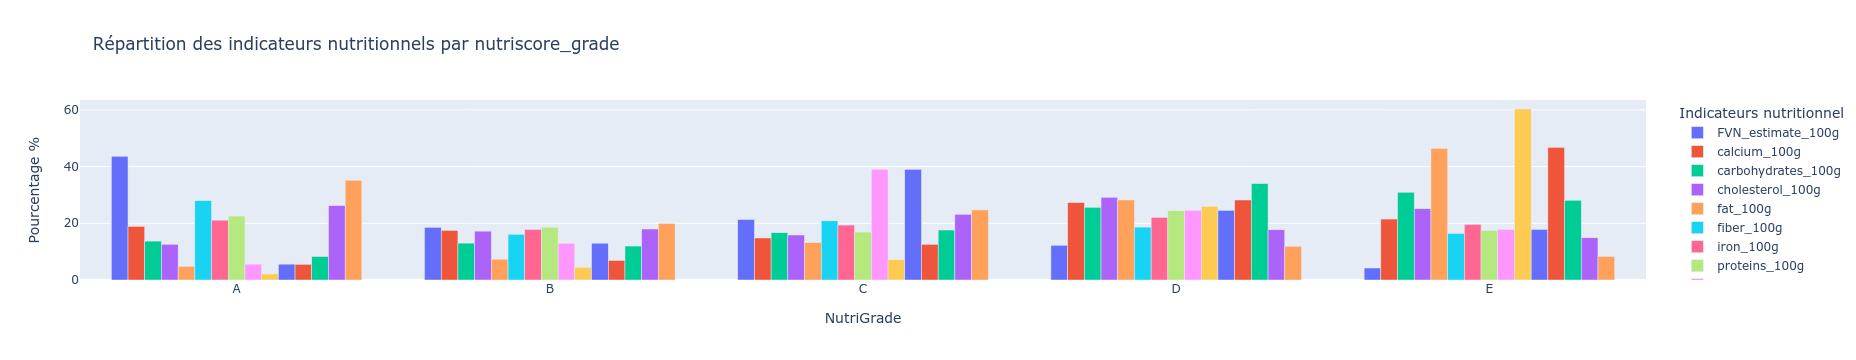

In [101]:
fig = px.bar(
    title="Répartition des indicateurs nutritionnels par nutriscore_grade",
    data_frame=mean_nutri_pd,
    #x="", y="", color="",
    barmode='group',
    labels={
        "variable": "Indicateurs nutritionnels",
        "index": "NutriGrade",
        "value": "Pourcentage %"
    },
    width=1000,
)

fig.show()

> En isolant les colonnes une à une *(cliquez sur les noms)*, on constate 4 types de tendances:
>
> - Celles qui tendent à augmenter avec le grade *(de A vers E)*; <br>`calcium_100g`, `carbohydrates_100g`, `cholesterol_100g`, `fat_100g`, `saturated-fat_100g`.
>
> - Celles qui tendent à augmenter avec le grade, mais avec un maximum sur D au lieu de E; <br>`salt_100g`, `sodium_100g`.
>
> - Celles qui tendent à baisser avec le grade, mais avec un rebond en C; <br>`FVN_estimate_100g`, `fiber_100g`
>
> - Et celles qui tendent à rester assez neutres vis à vis des différents grades *(il peut y avoir un grade plus présent qu'un autre, mais c'est assez peu marqué)*.

#### Ensuite, vérifions les boites à moustache pour tous les indicateurs nutritionnels afin de voir si des tendances se dessinent.

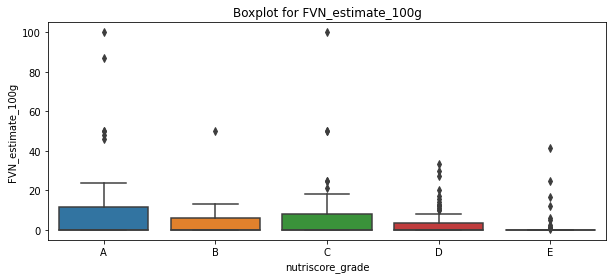

<function __main__.select_boxplot1(colonne)>

In [307]:
data_boxplot1 = data_clean.sample(frac=0.1).copy()

def select_boxplot1(colonne):
    fig = plt.figure(figsize=(10,4))

    sns.boxplot(data=data_boxplot1, x='nutriscore_grade', y=colonne, order='ABCDE')
    plt.title(f"Boxplot for {colonne}")

    plt.show()

interact(select_boxplot1, colonne=var_nutri)

> Comme vu dans la seconde [table de corrélation de la partie 5.2](#P03_correlation_num_nom), les différentes colonnes de valeurs nutritionnelles présentes un moindre degrès de corrélation avec la colonne `nutriscore_grade` qu'avec la colonne `nutriscore_score`.<br>Cette tendance se vérifie une fois encore avec les box-plots ci-dessus; les corrélations ne sont pas flagrantes.
>
> Il semble donc plus intéressant d'essayer de prédire le `nutriscore_score` plutôt que le `nutriscore_grade`.

---

### Objectif 3 : Vérifions la relation entre `nutriscore_grade` et `nutriscore_score`

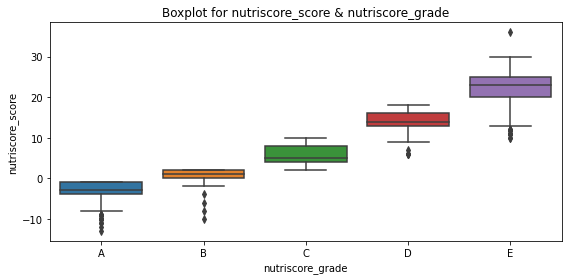

In [303]:
fig = plt.figure(figsize=(8,4))

sns.boxplot(data=data_clean, x='nutriscore_grade', y='nutriscore_score', order='ABCDE')
plt.title(f"Boxplot for nutriscore_score & nutriscore_grade")

fig.tight_layout()
plt.show()

> Sur ce boxplot `nutriscore_score` vs `nutriscore_grade`, on perçoit immédiatement une relation forte.
>
> La documentation indique les plages suivantes pour les aliments:
> - [-15;-1] pour le **A**
> - [0;2] pour le **B**
> - [3;10] pour le **C**
> - [11;18] pour le **D**
> - [19;40] pour le **E**
>
> La documentation indique les plages suivantes pour les boissons:
> - Uniquement l'eau pour le **A**
> - [-15;1] pour le **B**
> - [2;5] pour le **C**
> - [6;9] pour le **D**
> - [10;40] pour le **E**
>
> On remarque des outliers, mais on constate que ces valeurs semblent majoritairement respectées.

Une autre façon de vérifier la relation entre ces deux colonnes et de regarder comment elles réagissent ensemble au regard des valeurs nutritionnelles...

#### Affichons un graphique permettant de confronter chaque variable nutritionnelle à `nutriscore_score` et `nutriscore_grade` en même temps

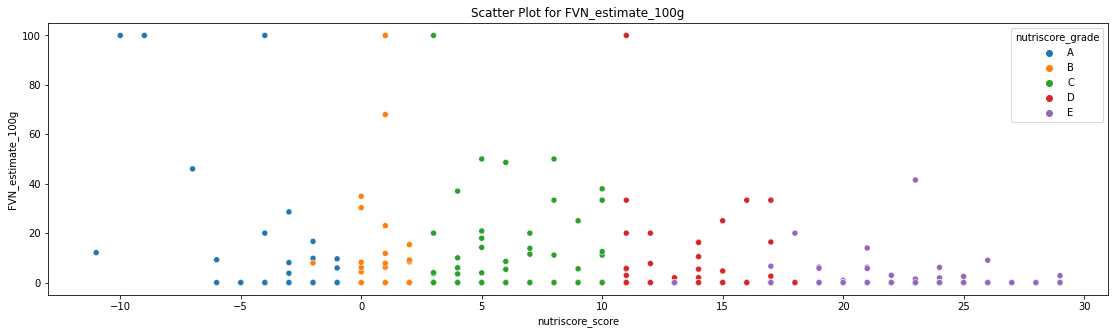

<function __main__.select_boxplot2(colonne)>

In [103]:
data_boxplot2 = data_clean.sample(frac=0.1).copy()

def select_boxplot2(colonne):
    fig = plt.figure(figsize=(19,5))

    sns.scatterplot(x=data_boxplot2['nutriscore_score'], y=data_boxplot2[colonne], hue=data_boxplot2['nutriscore_grade'], hue_order='ABCDE')
    plt.title(f"Scatter Plot for {colonne}")

    plt.show()

interact(select_boxplot2, colonne=[*var_nutri, 'nutriscore_score'])

> Si on se concentre purement sur la relation entre le `nutriscore_score` et le `nutriscore_grade`, on peut voir que la distribution du `nutriscore_grade` semble globalement respecter le positionnement escomptée sur l'échelle des le `nutriscore_score`.
>
> Il y a bien quelques `grades` en dehors des `scores` attendus, mais c'est un phénomènes assez restreint qui semble surtout toucher le groupe **E** *(qui déborde sur le groupe **D**)* et dans une moindre mesure le groupe **D** *(qui déborde sur le groupe **C**)*.

> Si on compare le `nutriscore_score` et le `nutriscore_grade` avec les colonnes des indicateurs nutritionnels, on remarque que certaines colonnes ne sont visuellement pas corrélées avec elles, alors que d'autres sont en revanches très marquées dans leur distribution. C'est le cas pour :
>
> - `sugars_100g` *(faible en A, fort en E)*
> - `energy_100g` *(faible en A, fort en E)*
> - `saturated_fat_100g` *(faible en A, fort en E)*
> - `fat_100g` *(faible en A, fort en E)*
> - `FVN_estimate_100g` *(fort en A, faible en E)*
> - `fiber_100g` *(fort en A, faible en E)*
> - `salt_100g` *(faible en A et D et plus fort en B, C, D)*
> - `sodium_100g` *(faible en A et D et plus fort en B, C, D)*
> - `proteins_100g` *(faible en A et D et plus fort en B, C, D)*
>
> Ces colonnes sont certainement les plus intéressantes pour préparer un modèle de prédiction du `nutriscore_score` et donc du `nutriscore_grade`. <br>On remarque d'ailleurs que ce sont à peu près les colonnes que l'on a identifié comme indéressantes en regard de la documentation du Nutriscore.

---

### Objectif 4 :  Vérifions les relations `pnns_groups_2` vs `nutriscore_score` et `nutriscore_grade`

#### Regardons la répartition des catégories `pnns_groups_2` sur les différents grade de `nutriscore_grade`

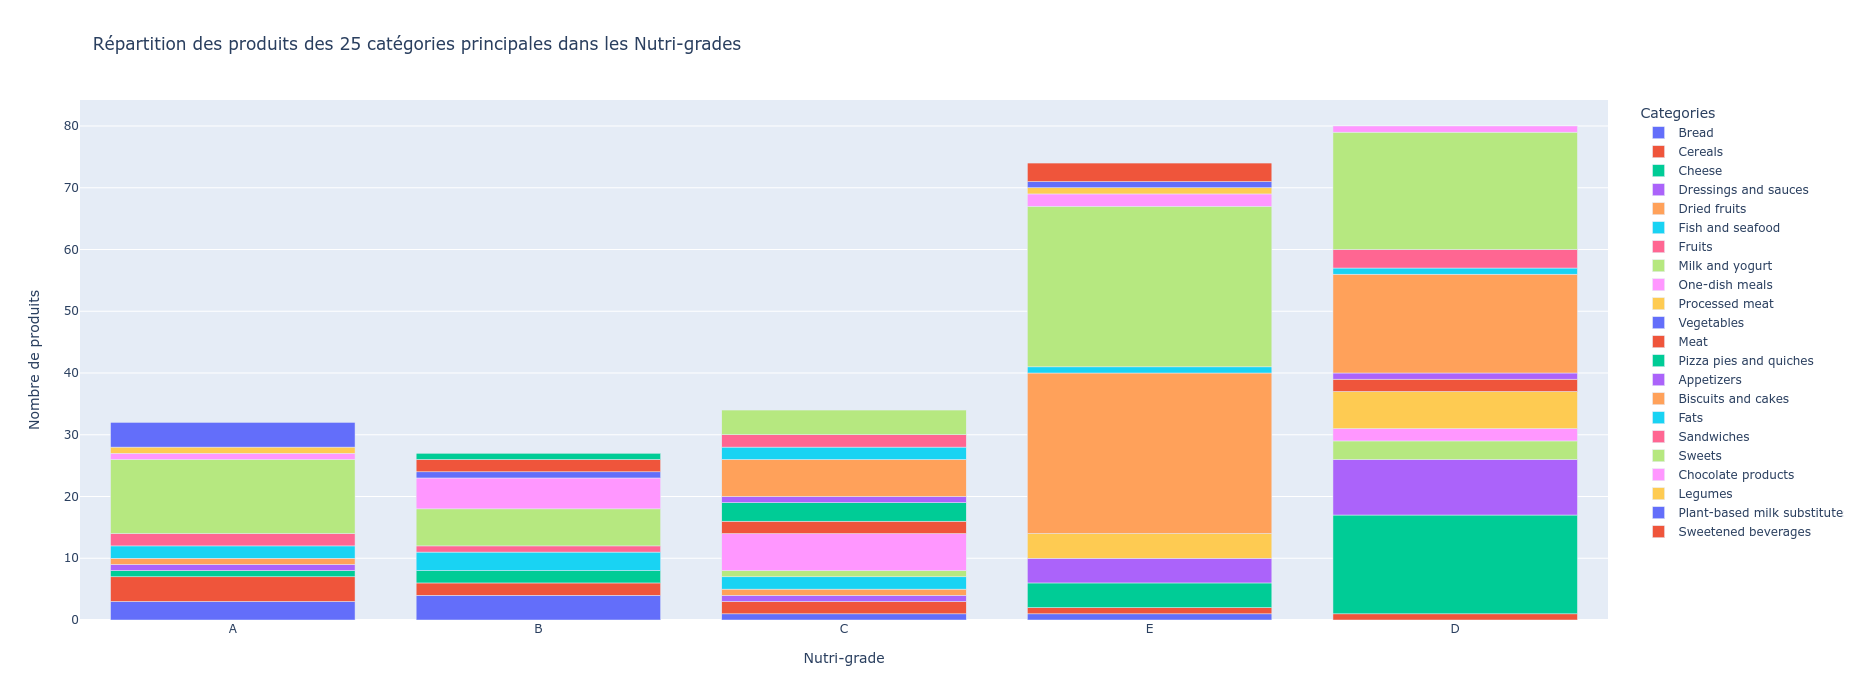

In [104]:
data_bargraph1 = data_clean.sample(frac=0.1).copy()

def select_bargraph1(nombre_categories):
    top_categories = list(data_bargraph1['pnns_groups_2'].value_counts(dropna=True)[:nombre_categories].index)

    #--- prepare data
    #data_tmp = data_clean.copy()
    #data_tmp['category'] = data_tmp['pnns_groups_2']
    #data_tmp.loc[~data_tmp['pnns_groups_2'].isin(top_categories),'category'] = 'OTHERS'
    #top_categories.append('OTHERS')

    #--- select data
    selection = data_bargraph1.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
    selection.rename(columns={0:'count'}, inplace=True)
    data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

    #--- graph
    fig = px.bar(data_graph, 
             x="nutriscore_grade",
             y="count",
             color="pnns_groups_2",
             title=f"Répartition des produits des {nombre_categories} catégories principales dans les Nutri-grades",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'nutriscore_grade': ['a','b','c','d','e']},
             height=700,
             width=1000,
            )
    fig.show()

interact(select_bargraph1, nombre_categories=widgets.IntSlider(min=1, max=40, step=1, value=25));

En explorant ce graphique interactif, on constate que :

> Le `grade A` semble contenir des **aliments bruts**; *légumes*, *céréales*, *fruits*, *viandes*, *poissons* et *produits laitiers*. Mais aussi **quelques produits transformés** comme des *plats-cuisinés* et *sucreries* qui sont plus surprenants.

> Le `grade B` semble contenir des **aliments bruts** et des **produits transformés**; *plats-cuisinés*, *produits-laitiers*, *viandes*, *poissons*, *céréales**, *pains*...

> Le `grade C` semble contenir des **produits bruts gras** et des **produits transformés**; *plats-cuisinés*, *huiles*, *sauces*, *biscuits & cakes*, *sucreries*, *viandes transformées* mais aussi quelques *viandes* et *poissons*...

> Le `grade D` semble contenir des **produits transformés gras / sucrés / salés**; *fromages*, *bicuits & cakes*, *sucreries*, *viandes transformées*, *poissons*, *sauces*, ...

> Le `grade E` semble contenir des **produits transformés gras / sucrés / salés** plus orientés encas; *biscuits & cakes*, *sucreries*, *viandes transformées*, *chocolats*, *boissons sucrées*...

#### Regardons à présent pour chacune de ces catégories `pnns_groups_2` leur répartition dans les `nutriscore_grade`

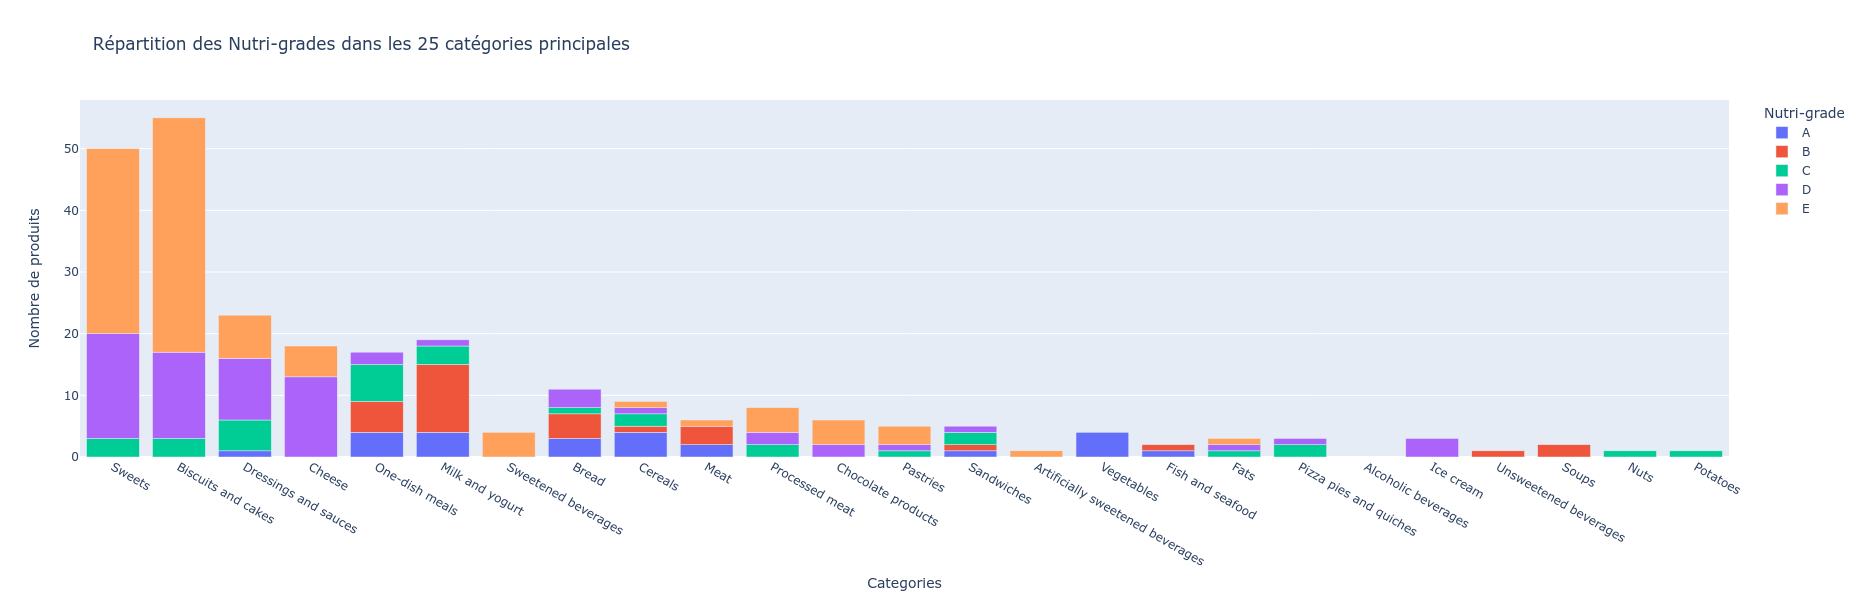

In [105]:
data_bargraph2 = data_clean.sample(frac=0.1).copy()

def select_bargraph2(nombre_categories):
    top_categories = list(data_bargraph2['pnns_groups_2'].value_counts(dropna=True)[:nombre_categories].index)

    #--- select data
    selection = data_bargraph2.groupby(['nutriscore_grade', 'pnns_groups_2']).size().reset_index()
    selection.rename(columns={0:'count'}, inplace=True)
    data_graph = selection[selection['pnns_groups_2'].isin(top_categories)]

    #--- graph
    fig = px.bar(data_graph, 
             x="pnns_groups_2",
             y="count",
             color="nutriscore_grade",
             title=f"Répartition des Nutri-grades dans les {nombre_categories} catégories principales",
             labels={'count': 'Nombre de produits', 'nutriscore_grade':'Nutri-grade', 'pnns_groups_2':'Categories'},
             category_orders={'pnns_groups_2': top_categories},
             height=600,
             width=1000,
            )
    fig.show()

interact(select_bargraph2, nombre_categories=widgets.IntSlider(min=1, max=40, step=1, value=25));

Si l'on prend quelques catégories emblématiques, on constate que le classement est assez cohérant avec ce que l'on à découvert plus haut *(tendances à monter en grade de A vers E, avec le sucre, le gras, le sel...)*

> Les `Vegetables` *(légumes)* sont essentiellement classés `A`.

> Les `Milk and yogurt` *(lait & yahourts)* sont essentiellement classés `B` et `C`

> Les `Sweets` *(sucreries)* sont essentiellement classés `D` et `E`.

---

### Conclusion des analyses multivariées


> Sur la base de la **documentation NutriScore**, il faudrait sélectionner les colonnes suivantes:
>
> Éléments défavorables au score:
> - `energy_100g` << *Apport calorique pour cent grammes*
> - `saturated-fat_100g` << *Teneur en graisses saturées*
> - `sugars_100g` << *Teneur en sucre*
> - `salt_100g` << *Teneur en sel*
>
> Éléments favorables au score:
> - `FVN_estimate_100g` << *Teneur en fruits, légumes, légumineuses, oléagineux, huiles de colza, de noix et d'olive*
> - `fiber_100g`  << *Teneur en fibres*
> - `proteins_100g` << *Teneur en protéines*

> Sur la base des **tables de corrélations**, il faudrait sélectionner les colonnes suivantes:
>
> - `saturated-fat_100g` = 0.58 / 0.64
> - `energy_100g` = 0.58 / 0.60
> - `fat_100g` = 0.47 / 0.59
> - `sugars_100g` = 0.43 / 0.33
> - `carbohydrates_100g` = 0.24 / 0.18
> - `cholesterol_100g` = 0.19 / 0.26
> - `sodium_100g` = 0.16 / 0.34
> - `salt_100g` = 0.15 / 0.34
> - `vitamin-c_100g` = -0.13 / -0.27
> - `fiber_100g` = -0.17 / -0.2
> - `FVN_estimate_100g` = -0.24 / -0.19

> Sur la base des **coefficients de détermination R²** des régressions linéaires opposant `nutriscore_score` aux différentes colonnes nutritionnelles, il faudrait sélectionner les colonnes suivantes:
> - R² `energy_100g`= 0.35
> - R² `saturated-fat_100g` = 0.35
> - R² `fat_100g` = 0.25
> - R² `sugars_100g` = 0.22

> Sur la base de l'analyse visuelle des graphiques opposant `nutriscore_score` & `nutriscore_grade` aux différentes colonnes nutritionnelles, il faudrait sélectionner les colonnes suivantes:
> - `energy_100g` *(faible en A, fort en E)*
> - `saturated_fat_100g` *(faible en A, fort en E)*
> - `sugars_100g` *(faible en A, fort en E)*
> - `fat_100g` *(faible en A, fort en E)*
> - `FVN_estimate_100g` *(fort en A, faible en E)*
> - `fiber_100g` *(fort en A, faible en E)*
> - `salt_100g` *(faible en A et D et plus fort en B, C, D)*
> - `sodium_100g` *(faible en A et D et plus fort en B, C, D)*


> Comme on a vu que certaines colonnes sont très proches voir redondantes, on va les éliminer et **garder la liste suivante** pour consuire une ACP et un test statistique:
>
> - **`energy_100g`**
> - **`saturated-fat_100g`**
> - **`sugars_100g`**
> - **`salt_100g`**
> - **`FVN_estimate_100g`**
> - **`fiber_100g`**

---

### 5.3 Analyse en composantes principales <a class="anchor" id="pca"></a>

L'analyse en composantes principales (ACP ou PCA en anglais) est une méthode qui consiste à transformer des variables liées entre elles *(dites « corrélées » en statistique)* en nouvelles variables décorrélées les unes des autres. Ces nouvelles variables sont nommées **composantes principales** ou axes principaux. Elle permet de résumer l'information en réduisant le nombre de variables, ou de produire des modèles plus légers.

#### **a**) Normalisation des données
Une ACP consiste à rechercher les axes qui maximisent la variance du jeu de données, il convient donc de normaliser les données pour que tous les axes aient un poids équivalent. <br>Notre jeu de données présente des variables qui ne sont pas du même ordre de grandeur *(`energy_100g` est bien plus grande que les autres)* il faut donc le normaliser pour éviter que certaines variables ne mettent tout leur poids dans la première composante principale. 

In [308]:
var_nutri_pca = [
    'energy_100g',
    'saturated-fat_100g',
    'sugars_100g',
    'FVN_estimate_100g',
    'fiber_100g',
    'salt_100g',
    
    #'fat_100g',
    #'sodium_100g',
    #'proteins_100g',
]

In [309]:
X = data_clean[var_nutri_pca].copy()
Y = data_clean['nutriscore_score']
Z = data_clean['nutriscore_grade']

In [310]:
from sklearn import preprocessing

In [311]:
std_scale = preprocessing.StandardScaler().fit(X)

In [312]:
X_scaled = std_scale.transform(X)
# pd.DataFrame(X_scaled, columns=data_clean[var_nutri_pca].columns)

#### **b**) Appliquons l'ACP puis affichons l'éboulis des valeurs propres

In [111]:
from sklearn import decomposition

In [112]:
pca = decomposition.PCA(n_components=len(var_nutri_pca))

In [113]:
pca.fit(X_scaled)

PCA(n_components=6)

In [313]:
# pca.explained_variance_ratio_

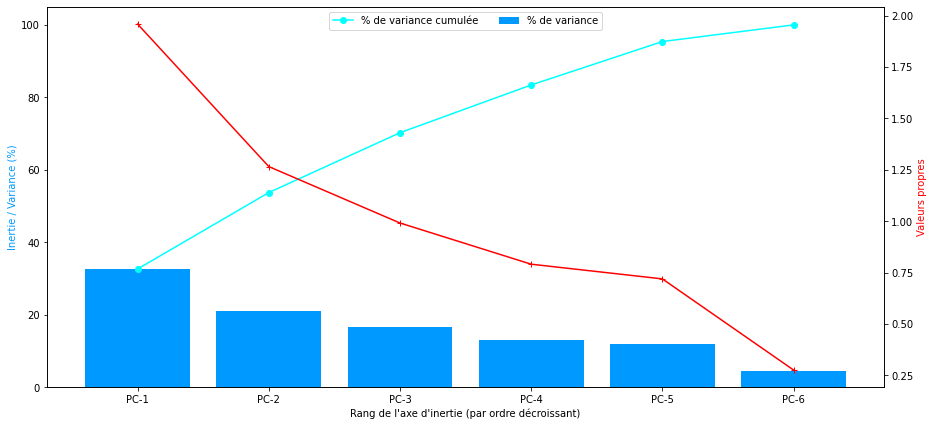

In [326]:
scree = pca.explained_variance_ratio_*100
eigenvalues = pca.explained_variance_
titles = [f"PC-{i+1}" for i in range(pca.n_components)]

fig = plt.figure(figsize=(15,7))
axis_1 = fig.add_subplot(111)
axis_1.bar(titles, scree, label='% de variance', color='#0099FF')
axis_1.plot(titles, scree.cumsum(),c="cyan",marker='o', label='% de variance cumulée')
axis_1.set_ylabel(r"Inertie / Variance (%)", color='#0099FF')
axis_1.set_xlabel(r"Rang de l'axe d'inertie (par ordre décroissant)")
axis_1.legend(loc=9, ncol=2)

axis_2 = axis_1.twinx()
axis_2.plot(titles, eigenvalues,c="red",marker='+', label="eigenvalues")
axis_2.set_ylabel(r"Valeurs propres", color='#FF0000')
#axis_2.legend(loc=5)

plt.show()

In [322]:
egeinvalues = pd.DataFrame({"Valeurs propres":pca.explained_variance_, "% des valeurs propres":pca.explained_variance_ratio_}, index=[i+1 for i in range(pca.n_components)])
egeinvalues['% cumulé'] = egeinvalues['% des valeurs propres'].cumsum()
egeinvalues

Valeurs propres  % des valeurs propres  % cumulé
1            1.959                  0.326     0.326
2            1.265                  0.211     0.537
3            0.991                  0.165     0.702
4            0.791                  0.132     0.834
5            0.719                  0.120     0.954
6            0.276                  0.046     1.000

A partir de cet éboulis des valeurs propres, on peut déterminer quel fraction il convient de garder pour créer un jeu de données allegé tout en minimisant les pertes d'information.<br>
Pour ce faire il existe *(au moins)* 3 méthodes que voici:

> Si l'on utilise la **méthode du coude**, il convient de choisir **2** *composantes principales*.

> Si l'on cherche à **retenir au moins 90% de la variance**, on voit qu'il faut garder **5** *composantes principales*. <br>*(Notons que les 2 premières composantes, possèdent 50% de l'inertie à elles seules)*

> Si l'on se fie au **critère de Keiser**, une composante principale doit représenter au moins (100/nombre_composants)% *(ici 100/6=16.66%)* pour présenter de l'intérêt. Dans le cas présent, ce sont les **3** *premières composantes principales*.


Mais dans l'immédiat, nous ne cherchons pas à réduire notre jeu de données, mais simplement à en faciliter la lecture et la compréhension.<br>
Nous allons donc travailler avec 4 premiers plans factoriels *(donc les 5 premières composantes principales)*.

In [328]:
# Projetons le jeu de données dans le nouvel espace

X_projected = pca.transform(X_scaled)
X_projected_pd = pd.DataFrame(X_projected)
X_projected_pd.shape

(7680, 6)

#### **c**) Étudions la variabilité des individus *(leurs ressemblances et différences)*

Regardons les variables `nutriscore_grade` et `pnns_groups_2` sous l'angle des divers plans factoriels trouvé par l'ACP, et affichons en parallèle les cercles de corrélation correspondants pour avoir une idée de ce à quoi corréspondent les axes.

Sur le cercle de corrélation, l'angle entre deux vecteurs indique leur coefficient de correlation.<br>Plus la pointe d'un vecteur se rapproche du cercle et mieux le vecteur est représenté dans le plan étudié <br>(+1 ou -1 sont donc des représentations parfaites sur la composante).

In [118]:
data_tmp = data_clean.copy()

In [120]:
data_tmp.reset_index(inplace=True, drop=True)

In [156]:
# Définissons une fonction permettant d'afficher les cercles de corrélations

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            #fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            #plt.show(block=False)

In [157]:
pcs = pca.components_

In [335]:
Sample_index = data_tmp[ data_tmp.nutriscore_grade.notnull() ].sample(frac=0.25, random_state=0).index
X_sample1 = X_projected_pd.loc[Sample_index]
X_sample1['Nutrigrade'] = data_tmp.loc[Sample_index]['nutriscore_grade']

In [336]:
num_cats = 10
top_categories = list(data_tmp['pnns_groups_2'].value_counts(dropna=True)[:num_cats].index)

In [337]:
Sample_index = data_tmp[ data_tmp.pnns_groups_2.isin(top_categories) ].sample(frac=0.25, random_state=0).index
X_sample2 = X_projected_pd.loc[Sample_index]
X_sample2['Categories'] = data_tmp.loc[Sample_index]['pnns_groups_2']

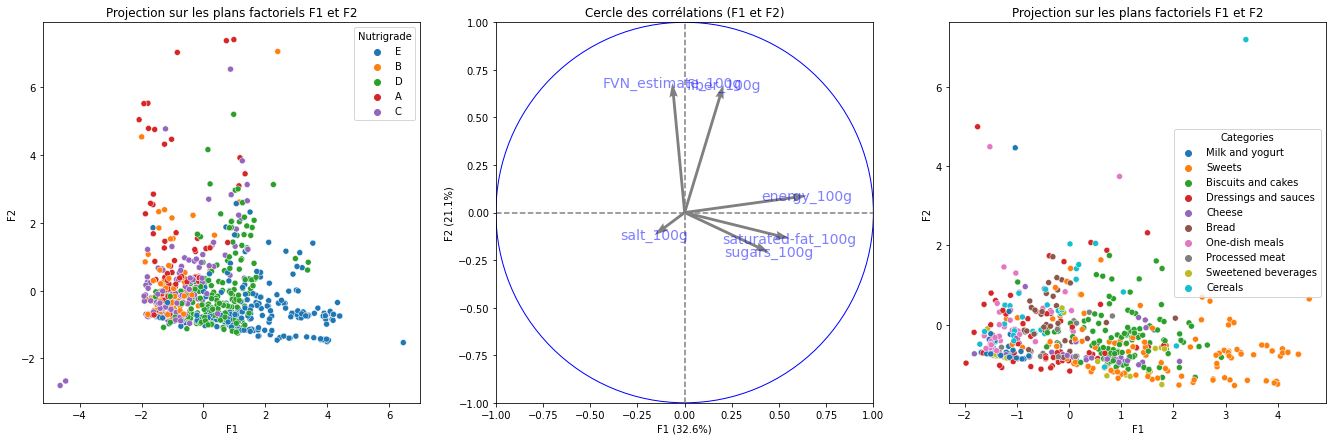

In [338]:
data_ACP1 = X_sample1.copy()
data_ACP2 = X_sample2.copy()

def select_ACP_nutrigrade(plan_factoriel):
    fig = plt.figure(figsize=(23,7))
    i = plan_factoriel-1
    num_p = 4
    
    ax = fig.add_subplot(1,3,1)
    sns.scatterplot(data=data_ACP1, x=i, y=i+1, hue='Nutrigrade')
    plt.title(f"Projection sur les plans factoriels F{i+1} et F{i+2}")
    ax.set_xlabel(f"F{i+1}")
    ax.set_ylabel(f"F{i+2}")
    
    ax = fig.add_subplot(1,3,2)
    display_circles(pcs, num_p+1, pca, [(i,i+1)], labels = X.columns, label_rotation=0)
    
    ax = fig.add_subplot(1,3,3)
    sns.scatterplot(data=data_ACP2, x=i, y=i+1, hue='Categories')
    plt.title(f"Projection sur les plans factoriels F{i+1} et F{i+2}")
    ax.set_xlabel(f"F{i+1}")
    ax.set_ylabel(f"F{i+2}")

    plt.show()

interact(select_ACP_nutrigrade, plan_factoriel=widgets.IntSlider(min=1, max=4, step=1, value=1));

> Sur les deux premiers plans factoriels, on constate que:
> - les produits avec des `nutriscore_grade` similaires ont tendance à se regrouper en clusters. Ce n'est pas clairement visible pour tous les grades cependant.
> - les produits avec des catégories `pnns_groups_2` similaires ont également tendance à se regrouper en clusters.

#### **d**) Étudions les liaisons entre les indicateurs nutritionnels et les composantes principales trouvées par l'ACP

In [128]:
comp_all = pd.DataFrame(pcs, columns=X.columns, index=[f"F{x+1}" for x in range(len(pcs))])

<AxesSubplot:>

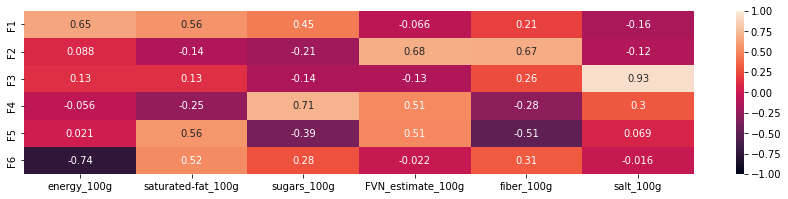

In [129]:
plt.figure(figsize=(15,3))
sns.heatmap(comp_all, vmin=-1, vmax=1, annot=True)

energy_100g = 0.67
saturated-fat_100g = 0.54
fiber_100g = 0.35
sugars_100g = 0.33

On retrouve assez fidèlement les informations présentes dans les cercles de corrélation des divers plans factoriels.

> Sur **F1**, les colonnes suivantes ressortent:
> - `energy_100g` = 0.67
> - `saturat<ed-fat_100g` = 0.54
> - `fiber_100g` = 0.35
> - `sugars_100g` = 0.33
> 
>> Cette première composante principale pourrait être un axe basé sur **l'apport énergetique**.

> Sur **F2**, les colonnes suivantes ressortent:
> - `salt_100g` = 0.46
> - `saturated-fat_100g`
> - `fiber_100g` = -0.41
> - `FVN_estimate_100g` = -0.71
> 
>> Cette seconde composante principale pourrait être un axe basé qui oppose les produits plutôt **gras** aux produits plutôt **secs**.

> Sur **F3**, les colonnes suivantes ressortent:
> - `salt_100g` = 0.58
> - `fiber_100g` = 0.57
> - `sugars_100g` = -0.55
> 
>> Cette troisième composante principale pourrait être un axe qui oppose les produits **salés** aux produits **sucrés**.

#### **e**) Étudions la décomposition des composantes principales entre les divers grades du `nutriscore_grade`

On affiche les **moyennes** par `nutriscore_grade` des valeurs sur chaque composante principales

In [130]:
Sample_index = data_tmp[ data_tmp.nutriscore_grade.notnull() ].sample(frac=0.25, random_state=0).index
X_sample = X_projected_pd.loc[Sample_index]
X_sample['Nutrigrade'] = data_tmp.loc[Sample_index]['nutriscore_grade']

In [131]:
pcs_grades = []
grades = ['A','B','C','D','E']
for grade in grades:
    pcs_grades.append(list(X_sample[ X_sample.Nutrigrade == grade].mean(numeric_only=True)))
 
pcs_grades_pd = pd.DataFrame(pcs_grades, index=grades, columns=[f"F{x+1}" for x in range(len(pcs))]).T

<AxesSubplot:>

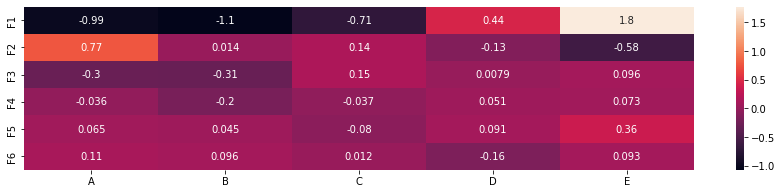

In [132]:
plt.figure(figsize=(15,3))
sns.heatmap(pcs_grades_pd, annot=True)

> - F1 fait une grosse différence entre les grades A,B,C d'une part et D,E d'autre part.
> - F2 fait à peu près la même chose mais en moins accentué et s'intéresse nettement moins à B.
> - F3 inverse la tendance et ne s'occupe plus que des extrêmes (A,E ou D dans une moins mesure).

--- 

### 5.4 Test statistique<a class="anchor" id="anova"></a>

Nous allons à présent vérifier statistiquement si les constatations faites précèdement concernant le rapport entre les differents `nutriscore_grade` et les indicateurs nutrionnels sélectionnés `energy_100g`, `saturated-fat_100g`, `sugars_100g`, `FVN_estimate_100g`, `fiber_100g`, `salt_100g`, sont **significatifs ou non**.

Commençons par établir les hypothèses que nous allons utiliser pour chaque indicateur nutritionnel conservé:
- **Hypothèse nulle $H_0$:** tous les grades ont les mêmes valeurs pour un indicateur nutrionnel donné; on ne peut pas différentier les grades.
- **Hypothèse alternative $H_1$:** au moins deux grades n'ont pas les mêmes valeurs pour un indicateur nutritionnel donné; on peut les différencier.

#### **a**) ANOVA *(ANalysis Of VAriance)*

Ce test permet comparer la différence de variance entre deux ou plusieurs groupes/catégories de variables numériques. <br>Donc de comparer une variable qualitatives comme le `nutriscore_grade` avec des variables quantitatives comme les indicateurs nutritionnels.

Pour être utilisable, l'ANOVA nécessite de respecter plusieurs hypothèses fondamentales:
- **Normalité de la distribution**
- **Indépendance des échantillons**

Nous avons vu lors des analyses univariées des variables numériques qu'aucune d'entre elles n'est de distribution *gaussienne*/*normale*. <br>Affichons à nouveau les diagrammes quantile-quantile *(QQplot)* qui ont le mérite d'être très parlant.

#### **b**) Diagrammes Quantile-Quantile

Le QQplot de comparaison d'une distribution observée avec une loi gaussienne réduite permet une validation subjective de la normalité :
- si les points sont alignés sur la première bissectrice c'est que la distribution suit probablement une loi de distribution gaussienne normalisée.
- si les points sont alignés sur une autre droite d'équation $x_i = a x_i^∗ + b$, c'est que la distribution suit une loi normale d'espérance b et d'écart type a. 

In [135]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm #, uniform

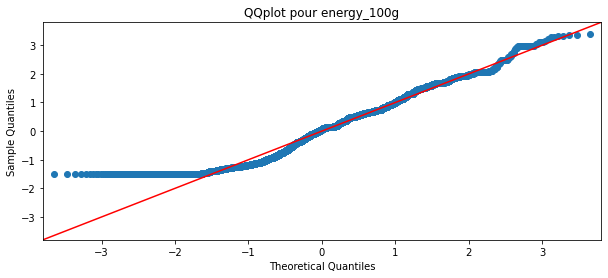

<function __main__.select_qqplot1(colonne)>

In [341]:
from scipy import stats

data_qqplot1 = data_clean.copy()

def select_qqplot1(colonne):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f"QQplot pour {colonne}")
    qqplot(data_qqplot1[data_qqplot1[colonne].notnull()][colonne], norm, fit=True, line="45", ax=ax)

interact(select_qqplot1, colonne=var_nutri_pca)

> On constate donc qu'**aucune des variables numériques considérées n'a une distribution gaussienne**.
>
> Il n'est donc **pas raisonnable d'utiliser l'ANOVA** pour tester la significativité de la variance entre les différents `nutriscore_grade`.
>
> Heureusement, il existe une alternative qui ne nécessite pas d'avoir une distribution normale; le **test de Kruskal-Wallis** qui au lieu de s'intéresser à la variance, se concentre sur les médianes.

#### **c**) Kruskal-Wallis
Cette alternative non paramétrique est utilisée comme l'ANOVA pour tester si des échantillons trouvent leur origine dans la même distribution. <br>Mais elle s'intéresse aux médianes de k populations ( k ⩾ 3) au lieu de leur variance.

- **Hypothèse nulle $H_0$:** les k échantillons sont confondus et proviennent d'un même échantillon d'une population. On ne peut pas les différencier.
- **Hypothèse alternative $H_1$:** les k échantillons ne sont PAS confondus, il existe une relation entre eux. On peut donc les différencier.

**Note:** Le test permet de comparer deux ou plusieurs échantillons indépendants **de taille similaire ou non**.

In [137]:
from scipy import stats

In [343]:
data_drop = data_clean[var_nutri_pca].copy()
#data_drop['nutriscore_score'] = data_clean['nutriscore_score']
data_drop['nutriscore_grade'] = data_clean['nutriscore_grade']

In [344]:
# Supprimons les lignes avec des valeurs nulles *(donc les lignes sans nutriscore_grade)*
data_drop.dropna(inplace=True)

#### Calculons la p-valeur et la statistique de test pour chaque indicateur nutritionnel sélectionné

In [345]:
for col in var_nutri_pca:
    s, p = stats.kruskal(*[data_drop[data_drop.nutriscore_grade == x][col] for x in ['A','B','C','D','E']])
    if p < 0.05:
        result="H0 est rejetée"
    else:
        result="H0 est validée"
    print(f"{col.rjust(25)} >> statistique = {s:9.2f} | p-valeur = {p:.2f} | {result}")

              energy_100g >> statistique =   1528.46 | p-valeur = 0.00 | H0 est rejetée
       saturated-fat_100g >> statistique =   1533.60 | p-valeur = 0.00 | H0 est rejetée
              sugars_100g >> statistique =    943.75 | p-valeur = 0.00 | H0 est rejetée
        FVN_estimate_100g >> statistique =    215.14 | p-valeur = 0.00 | H0 est rejetée
               fiber_100g >> statistique =     48.13 | p-valeur = 0.00 | H0 est rejetée
                salt_100g >> statistique =    320.88 | p-valeur = 0.00 | H0 est rejetée


Rappelons les hypothèses $H_0$ et $H_1$:

- **Hypothèse nulle $H_0$:** la médiane est égale dans tous les grades pour un indicateur nutrionnel donné; on ne peut pas les différentier.
- **Hypothèse alternative $H_1$:** au moins deux grades n'ont pas la même médiane pour un indicateur nutritionnel donné; on peut les différencier.

> On constate que pour chaque indicateur nutritionnel, la p-valeur du test de Kruskal-Wallis est **inférieure à un niveau de test ($\alpha$) de 0.05** *(5%)*, et donc l'**hypothèse nulle $H_0$ est rejetée** à chaque fois.
>
> Les tests statistiques démontrent donc qu'**il y a moins deux colonnes/grades dont les medianes des valeurs sont suffisament différentes pour être distinguées**.

> **L'ensemble du test confirme donc que ces differents indicateurs nutritionnels peuvent être des variables utiles pour un modèle prédictif dont le but est de prédire le `nutriscore_grade`.**

---
---

# 6. Conclusions sur la faisabilité de l'application<a class="anchor" id="conclusion"></a>

> 1. Les analyses de données et le test statistiques indiquent qu'il est **raisonnable de s'appuyer sur les colonnes nutritionnelles sélectionnées pour prédire le `nutriscore_score` ou le `nutriscore_grade`**.

> 2. L'ACP montrent que **la dimensionnalité du jeu de donnée pourrait être légèrement réduite** tout en conservant un pouvoir prédictif sensiblement équivalent.

> 3. Sur la base de cette EDA, on peut prendre **deux directions pour le modèle prédictif** : prédire le nutriscore_grade directement ou prédire le nutriscore_score puis le convertir en nutriscore_grade.